# GAM Based model

In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd


# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.isotonic import IsotonicRegression

from pygam import LogisticGAM, s
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression


import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

from pygam import LogisticGAM, s



from typing import Iterable, Any, Tuple, Dict
from pathlib import Path



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

# Data Preparation and stress construction

## Data preparation

In [2]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats



weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

# test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
test_periods = None

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']


initial_state = 'all'
print(f"\nProcessing initial MC state: {initial_state}")
# ---------- Merge + label prep ----------
train_df, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                            weather_data_path=weather_data_file,
                                                                            power_load_data_path=power_load_file,
                                                                            feature_names=feature_names_base,
                                                                            cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                            state_one_hot=True,
                                                                            initial_MC_state_filter=initial_state,
                                                                            technology_filter=technologies,
                                                                            test_periods=test_periods
                                                                            )


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

print(f"Encoding for 'Final_gen_state': {integer_encoding['Final_gen_state']}")

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']

Processing initial MC state: all
'State' in merged_data.columns : True
'State' in merged_data.columns : True
Standardized features (35): ['24h_min_load', 'CDD', '24h_max_load', 'Precip_1d', '2d_load_sum', 'Snow_depth', 'Precip_3d', 'Extreme_heat', 'Wind_speed', 'FDD', 'Precipitation', 'Station_level_pressure', 'Hourly_load_change', 'Extreme_cold', 'FDD3d', 'Tmin', 'HDD', 'Pressure_3hr_change', 'Sea_level_pressure', 'Wind_chill', 'Relative_humidi

In [3]:
test_frac = 0.2
N= len(train_df)
train_idx = np.random.choice(N, size=int((1 - test_frac) * N), replace=False)
test_idx = np.setdiff1d(np.arange(N), train_idx)
train_df, test_df = train_df.iloc[train_idx].reset_index(drop=True).copy(), train_df.iloc[test_idx].reset_index(drop=True).copy()

## Stress construction

In [4]:
def therm_load_stress(temp: float, load: float, T_nom = 25, L_rated=0.5) -> float:
    """Compute a stress metric based on temperature and power load."""
    # Simple example: stress increases with temperature and load
    stress = (temp - T_nom) * (load / L_rated)  # Normalize temp and load
    return stress

def cooling_stress(temp, humidity, B=0.4) -> float:
    """Compute a stress metric based on temperature and humidity."""
    # Example: stress increases with temperature and humidity
    stress = temp + B * humidity
    return stress

def rolling_hot_temp(temp: np.array,
                    T_nom: float,
                    max_lag_hours: int = 72) -> np.array:
    """
    Add ψ_hot(x_t) = sum_{τ=0}^{max_lag} exp(-τ/τ_half) * max(0, temp_{t-τ} - T_nom)
    as a new column 'psi_hot'.

    df must have columns 'Datetime_UTC' and 'Temperature' on an hourly grid.
    """
    tau_half = max_lag_hours / 2.0

    # excess temperature above threshold
    excess = np.maximum(0.0, temp - T_nom)   # shape (N,)

    # exponential weights for τ = 0..max_lag
    tau = np.arange(max_lag_hours + 1, dtype=float)
    weights = np.exp(-tau / tau_half)

    # causal convolution: each point t sees its past up to max_lag_hours
    psi = np.convolve(excess, weights, mode="full")[: len(excess)]

    return psi


def rolling_cold_temp(temp: np.array,
                    T_nom: float,
                    max_lag_hours: int = 72) -> np.array:
    """
    Add ψ_cold(x_t) = sum_{τ=0}^{max_lag} exp(-τ/τ_half) * max(0, T_nom - temp_{t-τ})
    as a new column 'psi_cold'.

    df must have columns 'Datetime_UTC' and 'Temperature' on an hourly grid.
    """
    tau_half = max_lag_hours / 2.0

    # excess temperature above threshold
    excess = np.maximum(0.0, T_nom - temp)   # shape (N,)

    # exponential weights for τ = 0..max_lag
    tau = np.arange(max_lag_hours + 1, dtype=float)
    weights = np.exp(-tau / tau_half)  

    # causal convolution: each point t sees its past up to max_lag_hours
    psi = np.convolve(excess, weights, mode="full")[: len(excess)]

    return psi


def composit_stress(psi_list: Iterable[np.array], weights: Iterable[float] = None) -> np.array:
    """Combine multiple stress metrics into a single composite stress metric."""
    if weights is not None:
        if len(psi_list) != len(weights):
            raise ValueError("Length of psi_list must match length of weights.")
    
    mu_list = [np.mean(psi) for psi in psi_list]
    sigma_list = [np.std(psi) for psi in psi_list]
    # Standardize each psi to have mean 0 and std 1
    psi_list = [(psi - mu) / sigma for psi, mu, sigma in zip(psi_list, mu_list, sigma_list)]
    comp = np.array([w * psi ** 2 for w, psi in zip(weights, psi_list)]).sum(axis=0) if weights is not None else np.sum(psi_list, axis=0)
    comp = np.sqrt(comp)
    return comp

In [5]:
def load_cdf_per_state(train_df:pd.DataFrame, test_df:pd.DataFrame) -> np.array:
    """Compute the empirical CDF of load values per state.
    df must contain columns 'State' and 'Load'."""
    test_df = test_df.copy()
    test_df['Load_CDF'] = None
    for state in test_df['State'].unique():
        state_mask = train_df['State'] == state
        state_loads = train_df.loc[state_mask, 'Load'].values
        sorted_loads = np.sort(state_loads)
        cdf = np.arange(1, len(sorted_loads) + 1) / len(sorted_loads)
        test_df.loc[state_mask, 'Load_CDF'] = np.interp(test_df.loc[state_mask, 'Load'].values, sorted_loads, cdf)
    return test_df['Load_CDF'].to_numpy(dtype=float)

In [6]:
temp = train_df['Temperature'].values
humidity = train_df['Relative_humidity'].values
load = load_cdf_per_state(train_df, train_df)
train_df['Load_CDF'] = load

test_df['Load_CDF'] = load_cdf_per_state(train_df, test_df)

T_nom = 25  # Nominal temperature in Celsius
L_rated = 1.0  # Rated load in per unit (example value)
lag_hours = 72

In [7]:
psi1 = therm_load_stress(temp, load, T_nom=T_nom, L_rated=L_rated)
psi2 = cooling_stress(temp, humidity)
# psi3 = rolling_hot_temp(temp, T_nom=T_nom, max_lag_hours=lag_hours)
# psi4 = rolling_cold_temp(temp, T_nom=T_nom, max_lag_hours=lag_hours)
psi3 = train_df['Temperature_3Dsum_hot'].values
psi4 = train_df['Temperature_3Dsum_cold'].values
train_df['psi1'] = psi1
train_df['psi2'] = psi2
train_df['psi3'] = psi3
train_df['psi4'] = psi4

stress = composit_stress([psi1, psi2, psi3, psi4], weights=np.ones(4)/4)
# stress = composit_stress([psi1, psi2], weights=np.ones(2)/2)

In [8]:
# test set features
temp_test = test_df['Temperature'].values
humidity_test = test_df['Relative_humidity'].values
load_test = load_cdf_per_state(train_df, test_df)
test_df['Load_CDF'] = load_test

psi1_test = therm_load_stress(temp_test, load_test, T_nom=T_nom, L_rated=L_rated)
psi2_test = cooling_stress(temp_test, humidity_test)
psi3_test = test_df['Temperature_3Dsum_hot'].values
psi4_test = test_df['Temperature_3Dsum_cold'].values
test_df['psi1'] = psi1_test
test_df['psi2'] = psi2_test
test_df['psi3'] = psi3_test
test_df['psi4'] = psi4_test

stress_test = composit_stress([psi1_test, psi2_test, psi3_test, psi4_test], weights=np.ones(4)/4)
# stress_test = composit_stress([psi1_test, psi2_test], weights=np.ones(2)/2)

**Notes**:

- T_norm=18.3 C?
- load : take cdf (thus uniformly distributed between 0 and 1)

# Importance weight estimation

### Stress weight

In [9]:
def compute_stress_weight(stress, gamma=0.5):
    """Compute stress weight based on stress metric and gamma parameter."""
    s = np.sort(stress)
    N = len(s)
    cdf = np.arange(1, N + 1) / N
    F = np.interp(stress, s, cdf)
    F=F.clip(0, 1-1e-12)
    weight = (1.01 - F) ** (-gamma)
    return weight

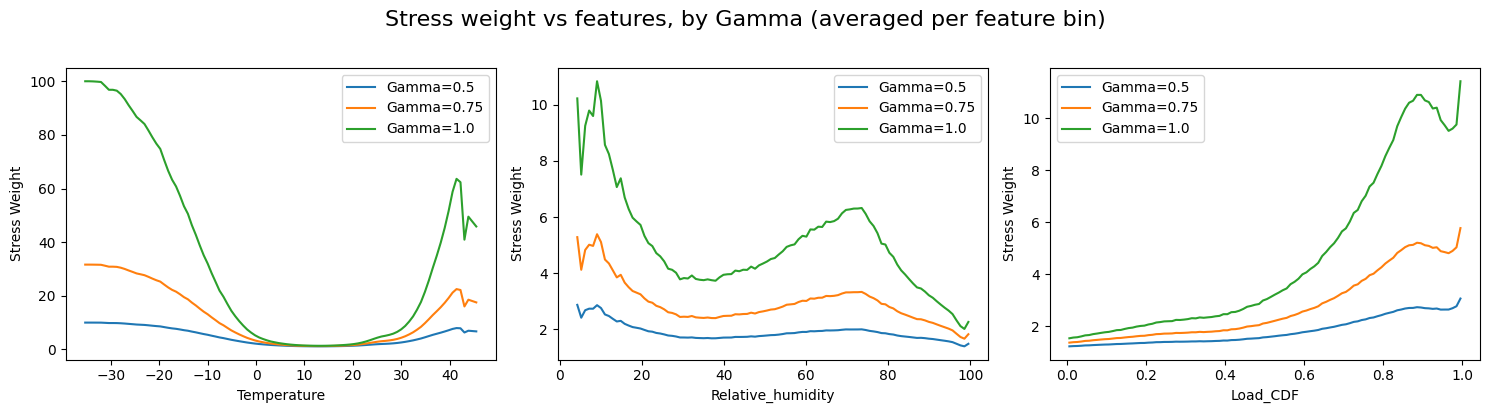

In [10]:
# Stress weights vs features et gamma

gamma_values = [0.5, 0.75, 1.0]
# gamma_values = [0.5]#1.0]
features = ['Temperature', 'Relative_humidity', 'Load_CDF']

fig, axs = plt.subplots(1, len(features), figsize=(5 * len(features), 4))

for gamma in gamma_values:
    stress_weights = compute_stress_weight(stress, gamma=gamma)
    for j, feature in enumerate(features):
        x = train_df[feature]
        x_bin_edges = np.linspace(x.min(), x.max(), 101)
        x_plot = []
        y_plot = []
        for i in range(len(x_bin_edges)-1):
            bin_mask = (x >= x_bin_edges[i]) & (x < x_bin_edges[i+1])
            bin_weights = stress_weights[bin_mask]
            if len(bin_weights) > 0:
                bin_mean = bin_weights.mean()
                bin_center = 0.5 * (x_bin_edges[i] + x_bin_edges[i+1])
                x_plot.append(bin_center)
                y_plot.append(bin_mean)
        axs[j].plot(x_plot, y_plot, label=f'Gamma={gamma}')
        axs[j].set_xlabel(feature)
        axs[j].set_ylabel('Stress Weight')
        axs[j].legend()

fig.suptitle('Stress weight vs features, by Gamma (averaged per feature bin)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [11]:
train_df['w_stress'] = compute_stress_weight(stress, gamma=1)
test_df['w_stress'] = compute_stress_weight(stress_test, gamma=1)

### Regional weight

In [12]:
train_df['month_sin'] = np.sin(2*np.pi*train_df['Datetime_UTC'].dt.month/12)
train_df['month_cos'] = np.cos(2*np.pi*train_df['Datetime_UTC'].dt.month/12)
test_df['month_sin'] = np.sin(2*np.pi*test_df['Datetime_UTC'].dt.month/12)
test_df['month_cos'] = np.cos(2*np.pi*test_df['Datetime_UTC'].dt.month/12)

In [13]:
region = 'NEW YORK'
regional_classifier_train_data = train_df[['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos', 'State']].copy()
regional_classifier_test_data = test_df[['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos', 'State']].copy()
regional_classifier_train_data.drop_duplicates(inplace=True)
regional_classifier_train_data.reset_index(drop=True, inplace=True)
regional_classifier_test_data.drop_duplicates(inplace=True)
regional_classifier_test_data.reset_index(drop=True, inplace=True)

regional_classifier_train_data['is_region'] = (regional_classifier_train_data['State'] == region).astype(int)
regional_classifier_test_data['is_region'] = (regional_classifier_test_data['State'] == region).astype(int)

regional_classifier_train_data.drop(columns=['State'], inplace=True)
regional_classifier_test_data.drop(columns=['State'], inplace=True)

classifier_feat = ['Temperature', 'Relative_humidity', 'Load_CDF', 'Temperature_3Dsum_hot', 'Temperature_3Dsum_cold', 'month_sin', 'month_cos']

In [14]:
X_train = regional_classifier_train_data[classifier_feat]
y_train = regional_classifier_train_data['is_region']

X_test = regional_classifier_test_data[classifier_feat]
y_test = regional_classifier_test_data['is_region']


regional_classifier = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",  # IMPORTANT if target region is rare
)

regional_classifier.fit(X_train, y_train)

p_test = regional_classifier.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, p_test))
print("Log loss:", log_loss(y_test, p_test))

ROC AUC: 0.6679967121442899
Log loss: 0.6423138299514726


In [15]:
n_total = len(regional_classifier_train_data)
n_target = np.sum(regional_classifier_train_data['is_region'])

train_df['w_region'] = regional_classifier.predict_proba(train_df[classifier_feat])[:, 1]*n_total/n_target

In [16]:
test_df['w_region'] = regional_classifier.predict_proba(test_df[classifier_feat])[:, 1]*n_total/n_target

### Combining and clipping

In [17]:
w_raw = train_df['w_region'].values*train_df['w_stress'].values
w_max = np.quantile(w_raw, 0.95)
w_clipped = np.clip(w_raw, None, w_max)
w = w_clipped/w_clipped.mean()

train_df['w'] = w

In [18]:
w_stress = train_df['w_stress'].values
w_max = np.quantile(w_stress, 0.95)
w_clipped = np.clip(w_stress, None, w_max)
w = w_clipped/w_clipped.mean()

train_df['w_stress'] = w_stress

In [19]:
w_region = train_df['w_region'].values
w_region_max = np.quantile(w_region, 0.95)
w_region_clipped = np.clip(w_region, None, w_region_max)
w_region_final = w_region_clipped/w_region_clipped.mean()
train_df['w_region_final'] = w_region_final

In [20]:
w_stress = test_df['w_stress'].values
w_max = np.quantile(w_stress, 0.95)
w_clipped = np.clip(w_stress, None, w_max)
w = w_clipped/w_clipped.mean()

test_df['w_stress'] = w

In [21]:
ESS = (np.sum(w))**2/np.sum(w**2)
print("Effective Sample Size (ESS):", 100*ESS/n_total , "% ")

Effective Sample Size (ESS): 18.750515148418124 % 


In [22]:
w_raw = test_df['w_region'].values*test_df['w_stress'].values
w_max = np.quantile(w_raw, 0.95)
w_clipped = np.clip(w_raw, None, w_max)
w = w_clipped/w_clipped.mean()

test_df['w'] = w

In [23]:
w_region = test_df['w_region'].values
w_region_max = np.quantile(w_region, 0.95)
w_region_clipped = np.clip(w_region, None, w_region_max)
w_region_final = w_region_clipped/w_region_clipped.mean()
test_df['w_region_final'] = w_region_final

### Some plots on weights

In [24]:
# ESS vs gamma et clipping

def compute_ess(gamma, quantile) -> float:
    """Compute Effective Sample Size (ESS) given weights w."""
    w_stress = compute_stress_weight(stress, gamma=gamma)
    w_region =  regional_classifier.predict_proba(train_df[classifier_feat])[:, 1]*n_total/n_target
    w_raw = w_region * w_stress
    w_max = np.quantile(w_raw, quantile)
    w_clipped = np.clip(w_raw, None, w_max)
    w = w_clipped / w_clipped.mean()
    ess = (np.sum(w))**2 / np.sum(w**2)
    return ess

gamma_values = np.linspace(0.5, 1, 16)
clipping_quantiles = np.linspace(0.9, 1.0, 16)

params_grid = [(g, q) for g in gamma_values for q in clipping_quantiles]
ess_results = [compute_ess(g, q) / n_total for g, q in tqdm(params_grid)]
ess_matrix = np.array(ess_results).reshape(len(gamma_values), len(clipping_quantiles))


100%|██████████| 256/256 [28:01<00:00,  6.57s/it]


In [33]:
quantile = 0.90
gamma = 0.5

w_stress = compute_stress_weight(stress, gamma=gamma)
w_region =  regional_classifier.predict_proba(train_df[classifier_feat])[:, 1]*n_total/n_target
w_raw = w_region * w_stress
w_max = np.quantile(w_raw, quantile)
w_clipped = np.clip(w_raw, None, w_max)
w = w_clipped / w_clipped.mean()
ess = (np.sum(w)**2) / np.sum(w**2)

In [35]:
ess/n_total

np.float64(1.3927277107705154)

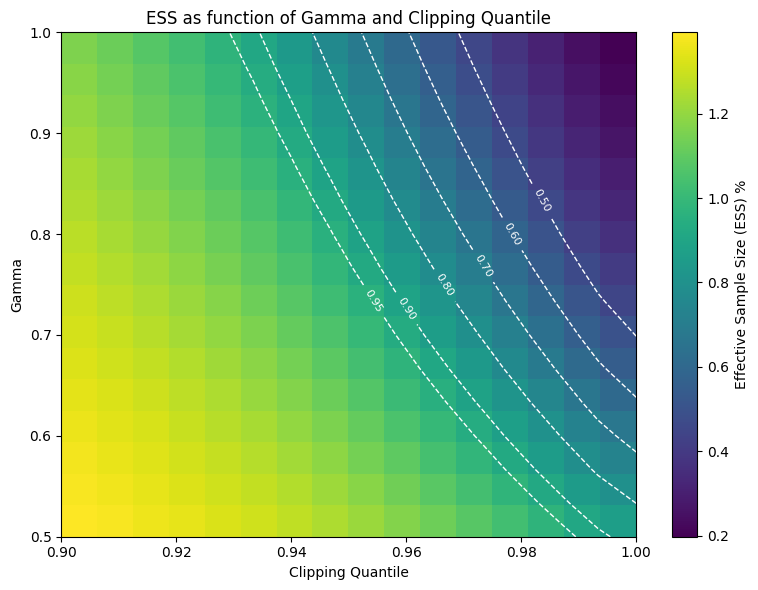

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(ess_matrix, origin='lower', aspect='auto',
           extent=[clipping_quantiles[0], clipping_quantiles[-1], gamma_values[0], gamma_values[-1]],
           cmap='viridis')
cbar = plt.colorbar(label='Effective Sample Size (ESS) %')
plt.xlabel('Clipping Quantile')
plt.ylabel('Gamma')
plt.title('ESS as function of Gamma and Clipping Quantile')

# Overlay contour lines for specified ESS levels
levels = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
# create meshgrid matching imshow axes
X, Y = np.meshgrid(clipping_quantiles, gamma_values)
cs = plt.contour(X, Y, ess_matrix, levels=levels, colors='white', linestyles='--', linewidths=1)
plt.clabel(cs, fmt='%.2f', inline=True, fontsize=8, colors='white')

plt.tight_layout()
plt.show()

# Model Training

In [22]:
features = ['Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4']
target = 'Final_gen_state'
importance_weight = 'w'
regional_weight = 'w_region_final'
stress_weight = 'w_stress'
compressed_data_weight = 'Data_weight'
other = ['Datetime_UTC', 'State', 'Initial_gen_state']

train_data = train_df[other+features+[target, importance_weight, regional_weight, stress_weight, compressed_data_weight]]
test_data = test_df[other+features+[target, importance_weight, regional_weight, stress_weight, compressed_data_weight]]

### Stage 1

In [23]:
def train_stage1_pygam_logistic(
    train_data: pd.DataFrame,
    current_state:int,
    features=('Temperature', 'Load_CDF', 'psi1', 'psi2', 'psi3', 'psi4'),
    target_col='Final_gen_state',
    importance_weight='w',
    compressed_data_weight='Data_weight',
    transform_quantile_space: bool = True,
    n_splines=25,
    spline_order=3,
    lam_grid=None,                 # 1D grid => diagonal search; list-of-arrays => full cartesian
    seed=42,
    objective="auto",              # 'auto' (=> UBRE for LogisticGAM), or 'GCV', 'UBRE', 'AIC', 'AICc'
    verbose=True,
):
    df = train_data.loc[train_data['Initial_gen_state'] == current_state].copy()

    # ---- y in {0,1} ----
    y = (df[target_col].to_numpy() != current_state).astype(int)

    # ---- weights ----
    if importance_weight in df.columns:
        w_imp = df[importance_weight].to_numpy(dtype=np.float64)
    else:
        w_imp = np.ones(len(df))
        print("No importance weight found, using uniform weights.")
    if compressed_data_weight in df.columns:
        w_cmp = df[compressed_data_weight].to_numpy(dtype=np.float64)
    else:
        w_cmp = np.ones(len(df))
        print("No compressed data weight found, using uniform weights.")
    w = w_imp * w_cmp
    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)

    # ---- quantile transform (fit on all train_data passed in here) ----
    # If you still want a train/val split to fit transforms only on a subset,
    # keep your split logic; otherwise this is simplest.
    if transform_quantile_space:
        transforms = {}
        rng = np.random.default_rng(seed)
        feature_data = df[['Datetime_UTC', 'State'] + list(features)].groupby(['Datetime_UTC', 'State']).first().reset_index()[features].copy()

        for f in features:
            x = feature_data[f].to_numpy()
            order = np.argsort(x)
            xs = x[order]
            u = (np.arange(len(xs)) + 0.5) / len(xs)

            iso = IsotonicRegression(y_min=0.0, y_max=1.0, increasing=True, out_of_bounds="clip")
            iso.fit(xs, u)
            transforms[f] = iso

        for f in features:
            df[f] = transforms[f].predict(df[f].to_numpy())
    else:
        transforms = None

    X = df[list(features)].to_numpy(dtype=np.float64)

    # ---- model terms ----
    terms = s(0, n_splines=n_splines, spline_order=spline_order)
    for j in range(1, X.shape[1]):
        terms = terms + s(j, n_splines=n_splines, spline_order=spline_order)

    gam = LogisticGAM(terms)

    # ---- lam grid ----
    if lam_grid is None:
        lam_grid = np.logspace(-3, 2, 8)

    # IMPORTANT:
    # - If you pass 1D lam, pyGAM searches diagonally (same lam for all terms).
    # - If you want full cartesian search, pass: lams = [lam_grid] * n_terms
    #   (n_terms here is number of spline terms, i.e., len(features))
    # lams = [lam_grid] * len(features)
    lams = lam_grid

    # ---- gridsearch chooses best lam by objective (GCV/UBRE/etc.) ----
    gam.gridsearch(X, y, weights=w, lam=lams, objective=objective, progress=verbose)
    # gam.gridsearch(X, y, lam=lams, objective=objective, progress=verbose)


    # best model is now stored in `gam`
    if verbose:
        print("best lam:", gam.lam)
        # gam.statistics_ typically includes the selected objective score
        # (keys vary a bit across versions)
        print("available statistics keys:", list(gam.statistics_.keys()))

    return {
        "features": list(features),
        "transform": transforms,
        "n_splines": int(n_splines),
        "spline_order": int(spline_order),
        "lam": gam.lam,          # note: per-term structure (list of lists)
        "objective": objective,
        "gam": gam,
    }

def train_stage2_pygam_logistic(
    train_data: pd.DataFrame,
    current_state:int,
    features=('psi1', 'psi2'),
    target_col='Final_gen_state',
    importance_weight='w_region_final',
    compressed_data_weight='Data_weight',
    transform_quantile_space: bool = True,
    n_splines=25,
    spline_order=3,
    lam_grid=None,                 # 1D grid => diagonal search; list-of-arrays => full cartesian
    seed=42,
    objective="auto",              # 'auto' (=> UBRE for LogisticGAM), or 'GCV', 'UBRE', 'AIC', 'AICc'
    verbose=True,
):
    df = train_data.loc[(train_data['Initial_gen_state'] == current_state)&(train_data['Final_gen_state'] != current_state)].copy()

    # ---- y in {0,1} ----
    target_state = 1 if current_state == 2 else 2
    y = (df[target_col].to_numpy() == target_state).astype(int)

    # ---- weights ----
    if importance_weight in df.columns:
        w_imp = df[importance_weight].to_numpy(dtype=np.float64)
    else:
        w_imp = np.ones(len(df))
        print("No importance weight found, using uniform weights.")
    if compressed_data_weight in df.columns:
        w_cmp = df[compressed_data_weight].to_numpy(dtype=np.float64)
    else:
        w_cmp = np.ones(len(df))
        print("No compressed data weight found, using uniform weights.")
    w = w_imp * w_cmp
    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)

    # ---- quantile transform (fit on all train_data passed in here) ----
    # If you still want a train/val split to fit transforms only on a subset,
    # keep your split logic; otherwise this is simplest.
    if transform_quantile_space:
        transforms = {}
        rng = np.random.default_rng(seed)
        feature_data = df[['Datetime_UTC', 'State'] + list(features)].groupby(['Datetime_UTC', 'State']).first().reset_index()[features].copy()

        for f in features:
            x = feature_data[f].to_numpy()
            order = np.argsort(x)
            xs = x[order]
            u = (np.arange(len(xs)) + 0.5) / len(xs)

            iso = IsotonicRegression(y_min=0.0, y_max=1.0, increasing=True, out_of_bounds="clip")
            iso.fit(xs, u)
            transforms[f] = iso

        for f in features:
            df[f] = transforms[f].predict(df[f].to_numpy())
    else:
        transforms = None

    X = df[list(features)].to_numpy(dtype=np.float64)

    # ---- model terms ----
    terms = s(0, n_splines=n_splines, spline_order=spline_order)
    for j in range(1, X.shape[1]):
        terms = terms + s(j, n_splines=n_splines, spline_order=spline_order)

    gam = LogisticGAM(terms)

    # ---- lam grid ----
    if lam_grid is None:
        lam_grid = np.logspace(-3, 2, 8)

    # IMPORTANT:
    # - If you pass 1D lam, pyGAM searches diagonally (same lam for all terms).
    # - If you want full cartesian search, pass: lams = [lam_grid] * n_terms
    #   (n_terms here is number of spline terms, i.e., len(features))
    # lams = [lam_grid] * len(features)
    lams = lam_grid

    # ---- gridsearch chooses best lam by objective (GCV/UBRE/etc.) ----
    gam.gridsearch(X, y, weights=w, lam=lams, objective=objective, progress=verbose)
    # gam.gridsearch(X, y, lam=lams, objective=objective, progress=verbose)


    # best model is now stored in `gam`
    if verbose:
        print("best lam:", gam.lam)
        # gam.statistics_ typically includes the selected objective score
        # (keys vary a bit across versions)
        print("available statistics keys:", list(gam.statistics_.keys()))

    return {
        "features": list(features),
        "transform": transforms,
        "n_splines": int(n_splines),
        "spline_order": int(spline_order),
        "lam": gam.lam,          # note: per-term structure (list of lists)
        "objective": objective,
        "gam": gam,
    }

def predict_proba_pygam(fit_dict, df: pd.DataFrame) -> np.ndarray:
    df = df.copy()
    transforms = fit_dict.get("transform", None)
    if transforms is not None:
        for f in fit_dict["features"]:
            df[f] = transforms[f].predict(df[f].to_numpy())

    X = df[fit_dict["features"]].to_numpy(dtype=np.float64)
    return np.asarray(fit_dict["gam"].predict_mu(X), dtype=np.float64)

In [40]:
stage1_models_region = {}
stage1_models = {}
stage2_models = {}

for initial_state in [0,1,2]:
    print(f"\nProcessing initial MC state: {initial_state}")
    # ---- Stage 1: fit initial -> failed ----
    fit1 = train_stage1_pygam_logistic(
        train_data=train_data,
        current_state=initial_state,
        features=features,
        target_col=target,
        importance_weight=importance_weight,
        compressed_data_weight=compressed_data_weight,
        transform_quantile_space=True,
        n_splines=25,
        spline_order=3,
        lam_grid=np.logspace(-2, 0, 8),
        seed=42,
        objective="auto",
        verbose=True,
    )

    stage1_models_region[initial_state] = fit1

    fit1 = train_stage1_pygam_logistic(
        train_data=train_data,
        current_state=initial_state,
        features=features,
        target_col=target,
        importance_weight='stress_weight',
        compressed_data_weight=compressed_data_weight,
        transform_quantile_space=True,
        n_splines=25,
        spline_order=3,
        lam_grid=np.logspace(-2, 0, 8),
        seed=42,
        objective="auto",
        verbose=True,
    )

    stage1_models[initial_state] = fit1

    # p_train = predict_proba_pygam(fit1, train_data)
    # p_test  = predict_proba_pygam(fit1, test_data)
    # print(p_train.min(), p_train.max(), p_train.mean())

    # ---- Stage 2: fit failed -> specific next state ----
    fit2 = train_stage2_pygam_logistic(
        train_data=train_data,
        current_state=initial_state,
        features=['psi1', 'psi2'],
        target_col=target,
        importance_weight='w_region_final',
        compressed_data_weight=compressed_data_weight,
        transform_quantile_space=True,
        n_splines=25,
        spline_order=3,
        lam_grid=np.logspace(-1, 2, 8),
        seed=42,
        objective="auto",
        verbose=True,
    )

    stage2_models[initial_state] = fit2
    
    # p_train = predict_proba_pygam(fit2, train_data)
    # p_test  = predict_proba_pygam(fit2, test_data)
    # print(p_train.min(), p_train.max(), p_train.mean())


Processing initial MC state: 0


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:03:04 ETA:   0:21:28
 25% (2 of 8) |######                    | Elapsed Time: 0:04:14 ETA:   0:12:43
 37% (3 of 8) |#########                 | Elapsed Time: 0:05:24 ETA:   0:09:00
 50% (4 of 8) |#############             | Elapsed Time: 0:06:34 ETA:   0:06:34
 62% (5 of 8) |################          | Elapsed Time: 0:07:44 ETA:   0:04:38
 75% (6 of 8) |###################       | Elapsed Time: 0:08:55 ETA:   0:02:58
 87% (7 of 8) |######################    | Elapsed Time: 0:10:05 ETA:   0:01:26
100% (8 of 8) |##########################| Elapsed Time: 0:20:28 Time:  0:20:28


best lam: [[np.float64(0.01)], [np.float64(0.01)], [np.float64(0.01)], [np.float64(0.01)], [np.float64(0.01)], [np.float64(0.01)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
No importance weight found, using uniform weights.


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:02:58 ETA:   0:20:49
 25% (2 of 8) |######                    | Elapsed Time: 0:04:08 ETA:   0:12:26
 37% (3 of 8) |#########                 | Elapsed Time: 0:05:18 ETA:   0:08:51
 50% (4 of 8) |#############             | Elapsed Time: 0:06:29 ETA:   0:06:29
 62% (5 of 8) |################          | Elapsed Time: 0:07:18 ETA:   0:04:23
 75% (6 of 8) |###################       | Elapsed Time: 0:08:49 ETA:   0:02:56
 87% (7 of 8) |######################    | Elapsed Time: 0:09:59 ETA:   0:01:25
100% (8 of 8) |##########################| Elapsed Time: 0:11:50 Time:  0:11:50
  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


best lam: [[np.float64(0.13894954943731375)], [np.float64(0.13894954943731375)], [np.float64(0.13894954943731375)], [np.float64(0.13894954943731375)], [np.float64(0.13894954943731375)], [np.float64(0.13894954943731375)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']


 12% (1 of 8) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 25% (2 of 8) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 37% (3 of 8) |#########                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 50% (4 of 8) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (5 of 8) |################          | Elapsed Time: 0:00:01 ETA:   0:00:00
 75% (6 of 8) |###################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 87% (7 of 8) |######################    | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


best lam: [[np.float64(100.0)], [np.float64(100.0)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']

Processing initial MC state: 1


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:00:39 ETA:   0:04:37
 25% (2 of 8) |######                    | Elapsed Time: 0:01:00 ETA:   0:03:00
 37% (3 of 8) |#########                 | Elapsed Time: 0:01:20 ETA:   0:02:14
 50% (4 of 8) |#############             | Elapsed Time: 0:01:41 ETA:   0:01:41
 62% (5 of 8) |################          | Elapsed Time: 0:02:02 ETA:   0:01:13
 75% (6 of 8) |###################       | Elapsed Time: 0:02:22 ETA:   0:00:47
 87% (7 of 8) |######################    | Elapsed Time: 0:02:43 ETA:   0:00:23
100% (8 of 8) |##########################| Elapsed Time: 0:03:04 Time:  0:03:04


best lam: [[np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
No importance weight found, using uniform weights.


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:00:39 ETA:   0:04:38
 25% (2 of 8) |######                    | Elapsed Time: 0:01:00 ETA:   0:03:01
 37% (3 of 8) |#########                 | Elapsed Time: 0:01:15 ETA:   0:02:05
 50% (4 of 8) |#############             | Elapsed Time: 0:01:36 ETA:   0:01:36
 62% (5 of 8) |################          | Elapsed Time: 0:01:56 ETA:   0:01:10
 75% (6 of 8) |###################       | Elapsed Time: 0:02:17 ETA:   0:00:45
 87% (7 of 8) |######################    | Elapsed Time: 0:02:38 ETA:   0:00:22
100% (8 of 8) |##########################| Elapsed Time: 0:02:59 Time:  0:02:59
  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 37% (3 of 8) |#########                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (5 of 8) |################         

best lam: [[np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)], [np.float64(0.07196856730011521)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']


 87% (7 of 8) |######################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


best lam: [[np.float64(100.0)], [np.float64(100.0)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']

Processing initial MC state: 2


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:00:59 ETA:   0:06:53
 25% (2 of 8) |######                    | Elapsed Time: 0:01:35 ETA:   0:04:45
 37% (3 of 8) |#########                 | Elapsed Time: 0:02:10 ETA:   0:03:38
 50% (4 of 8) |#############             | Elapsed Time: 0:02:36 ETA:   0:02:36
 62% (5 of 8) |################          | Elapsed Time: 0:03:02 ETA:   0:01:49
 75% (6 of 8) |###################       | Elapsed Time: 0:03:28 ETA:   0:01:09
 87% (7 of 8) |######################    | Elapsed Time: 0:04:04 ETA:   0:00:34
100% (8 of 8) |##########################| Elapsed Time: 0:04:40 Time:  0:04:40


best lam: [[np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']
No importance weight found, using uniform weights.


  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 12% (1 of 8) |###                       | Elapsed Time: 0:00:58 ETA:   0:06:52
 25% (2 of 8) |######                    | Elapsed Time: 0:01:24 ETA:   0:04:14
 37% (3 of 8) |#########                 | Elapsed Time: 0:01:50 ETA:   0:03:04
 50% (4 of 8) |#############             | Elapsed Time: 0:02:16 ETA:   0:02:16
 62% (5 of 8) |################          | Elapsed Time: 0:02:42 ETA:   0:01:37
 75% (6 of 8) |###################       | Elapsed Time: 0:03:08 ETA:   0:01:02
 87% (7 of 8) |######################    | Elapsed Time: 0:03:44 ETA:   0:00:32
100% (8 of 8) |##########################| Elapsed Time: 0:04:30 Time:  0:04:30
  0% (0 of 8) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


best lam: [[np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)], [np.float64(0.2682695795279725)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']


 12% (1 of 8) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 25% (2 of 8) |######                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 37% (3 of 8) |#########                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 50% (4 of 8) |#############             | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (5 of 8) |################          | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (6 of 8) |###################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 87% (7 of 8) |######################    | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


best lam: [[np.float64(100.0)], [np.float64(100.0)]]
available statistics keys: ['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values']


## Combining stages

In [204]:
class probabilistic_gam_two_stage_model:
    def __init__(self, initial_state: int, stage1_model: dict, stage2_model: dict):
        self.initial_state = initial_state
        self.stage1_model = stage1_model
        self.stage2_model = stage2_model

    def predict_proba(self, df: pd.DataFrame) -> np.ndarray:
        df = df.copy()
        N = len(df)
        p_final = np.zeros((N, 3), dtype=np.float64)


        # Stage 1: initial -> failed
        p_fail = predict_proba_pygam(self.stage1_model, df)
        # print(f"Stage 1 probs: min={p_fail.min()}, max={p_fail.max()}, mean={p_fail.mean()}")

        # Stage 2: failed -> specific next state
        p_next = predict_proba_pygam(self.stage2_model, df)
        # print(f"Stage 2 probs: min={p_next.min()}, max={p_next.max()}, mean={p_next.mean()}")

        p_final[:, self.initial_state] = 1.0 - p_fail
        target_state = 1 if self.initial_state == 2 else 2
        p_final[:, target_state] = p_fail * p_next
        other_state = 3 - self.initial_state - target_state
        p_final[:, other_state] = p_fail * (1.0 - p_next)

        return p_final

In [205]:
prob_models = {'A': probabilistic_gam_two_stage_model(0, stage1_models[0], stage2_models[0]),
               'D': probabilistic_gam_two_stage_model(1, stage1_models[1], stage2_models[1]),
               'O': probabilistic_gam_two_stage_model(2, stage1_models[2], stage2_models[2])}

# Validation

## Predicted probability vs stress

In [206]:
def CE_min(df, features):
    """Returns the probabilities that minimize the cross entropy on the test set (for comparison with model predictions)"""
    df_counts = df[features+['Data_weight']].copy()
    df_counts.rename(columns={'Data_weight': 'count'}, inplace=True)
    counts =  df_counts.groupby(features).sum('count')
    res = df.join(counts, on=features,  how='left')
    res["probability_CE_min"] = res['Data_weight'] / res['count']

    p0 = res.loc[res['Final_gen_state']==0]
    p1 = res.loc[res['Final_gen_state']==1]
    p2 = res.loc[res['Final_gen_state']==2]

    p0 = p0.groupby(['Datetime_UTC']+features).sum()
    p1 = p1.groupby(['Datetime_UTC']+features).sum()
    p2 = p2.groupby(['Datetime_UTC']+features).sum()

    p0 = p0['probability_CE_min']
    p1 = p1['probability_CE_min']
    p2 = p2['probability_CE_min']

    res = res.join(p0, on=['Datetime_UTC']+features, how='left', rsuffix='_0')
    res = res.join(p1, on=['Datetime_UTC']+features, how='left', rsuffix='_1')
    res = res.join(p2, on=['Datetime_UTC']+features, how='left', rsuffix='_2')

    res.fillna(0, inplace=True)

    probs = res[['probability_CE_min_0', 'probability_CE_min_1', 'probability_CE_min_2']].to_numpy()

    return probs

def plot_prob_inference_transitions(feature: str, all_features: list, prob_model: Any, data: pd.DataFrame):
    colors_states = {'A': 'green', 'D': 'red', 'O': 'blue'}
    for init_idx, initial_state in enumerate(['A', 'D', 'O']):
        data_df = data.loc[data['Initial_gen_state'] == init_idx].copy()
        model = prob_models[initial_state]

        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        feat_min = data_df[feature].min()
        feat_max = data_df[feature].max()
        feat_range = np.linspace(feat_min, feat_max, 100)
        gap_x = feat_range[1]-feat_range[0]

        inputs = data_df.copy()
        x_vals = data_df[feature].values
        weights = inputs['Data_weight'].values


        probs_model = model.predict_proba(data_df)
        prob_plot = []
        for x in feat_range:
            f_idx = np.where((inputs[feature] >= x - 2*gap_x) & (inputs[feature] < x + 2*gap_x))
            if sum(weights[f_idx]) == 0:
                prob_plot.append(np.array([np.nan, np.nan, np.nan]))
                continue
            prob_plot.append(np.average(probs_model[f_idx], axis=0, weights=weights[f_idx]))
        probs_model = np.array(prob_plot)
        empirical_feq = CE_min(data_df, all_features)

        avg_probs = []
        for x in feat_range:
            f_idx = np.where((x_vals >= x - 2*gap_x) & (x_vals < x + 2*gap_x))
            f = empirical_feq[f_idx]
            w = weights[f_idx]
            if sum(w) == 0:
                avg_probs.append(np.array([np.nan, np.nan, np.nan]))
                continue
            avg_prob = np.average(f, axis=0, weights=w)
            avg_probs.append(avg_prob)


            


        for j, end_state in enumerate(['A', 'D', 'O']):
            ax = axs[j]            
            ax.plot(feat_range, [ap[j] for ap in avg_probs], label=f'Empirical Avg', linestyle='-', linewidth=3, color=colors_states[end_state])
            
            ax.plot(feat_range, probs_model[:, j], label=f'GAM', linestyle='--')

            ax.set_title(f'End State: {end_state}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Predicted Transition Probability')
            ax.legend()
        plt.suptitle(f'Predicted Transition Probabilities vs {feature}', fontsize=16)
        plt.tight_layout()


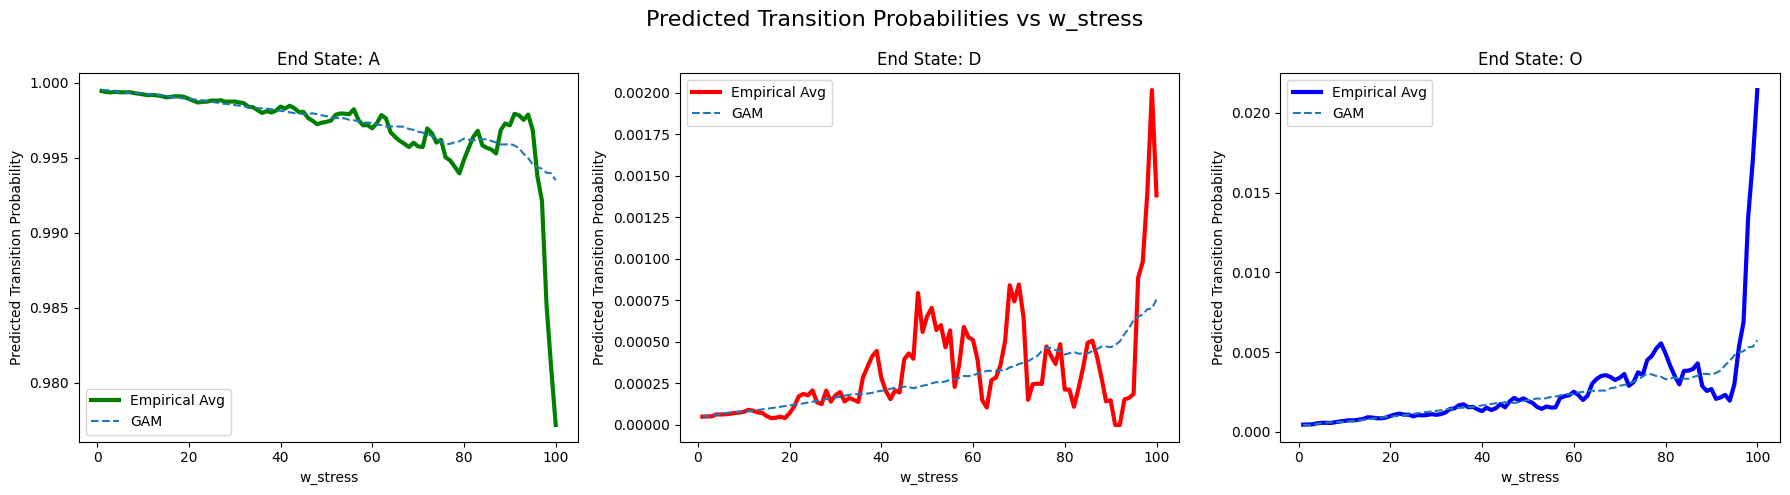

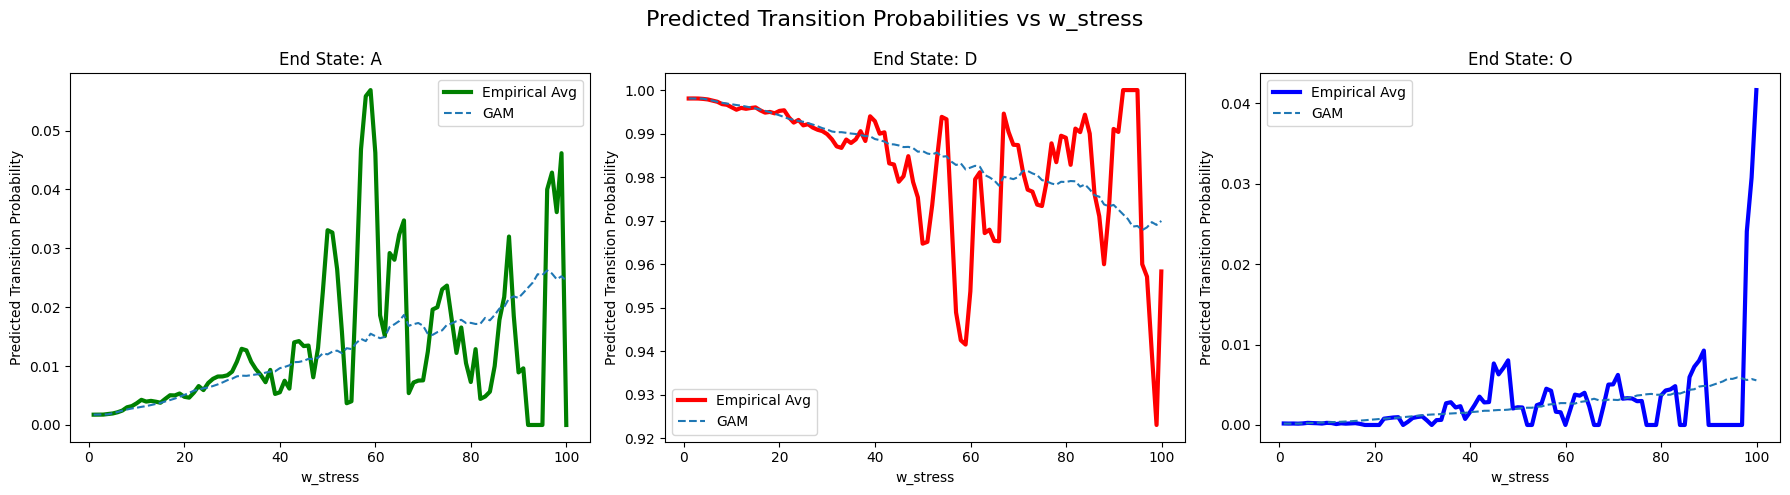

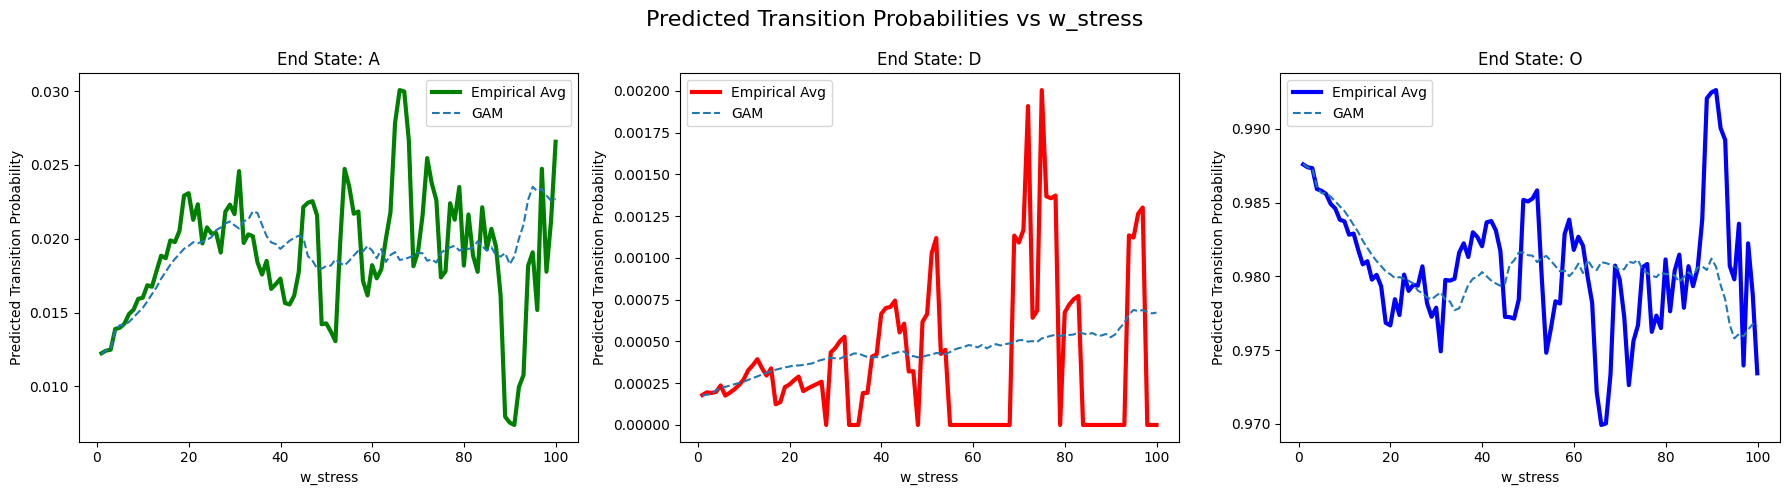

In [207]:
plot_prob_inference_transitions('w_stress', features, prob_models, test_data)

## Stress-Stratified Evaluation

In [ ]:
w_stress = train_data['w_stress']
q_stress_bin_edges = np.quantile(w_stress, [0.5, 0.9, 0.99])

test_data_stress_bins = {
    'Low': test_data.loc[test_data['w_stress'] < q_stress_bin_edges[0]],
    'Medium': test_data.loc[(test_data['w_stress'] >= q_stress_bin_edges[0]) & (test_data['w_stress'] < q_stress_bin_edges[1])],
    'High': test_data.loc[(test_data['w_stress'] >= q_stress_bin_edges[1]) & (test_data['w_stress'] < q_stress_bin_edges[2])],
    'Very High': test_data.loc[test_data['w_stress'] >= q_stress_bin_edges[2]],
}

In [209]:
def weighted_log_likelihood(y_true: np.ndarray, p_pred: np.ndarray, weights: np.ndarray) -> float:
    """Compute weighted log-likelihood for multi-class classification."""
    eps = 1e-12
    p_pred = np.clip(p_pred, eps, 1 - eps)
    log_likelihoods = np.log(p_pred[np.arange(len(y_true)), y_true])
    weighted_log_likelihood = np.sum(weights * log_likelihoods) / np.sum(weights)
    return weighted_log_likelihood


def weighted_calibration_error(y_bin, p, w, n_bins=10, strategy="quantile", eps=1e-12):
    y_bin = np.asarray(y_bin, float).reshape(-1)
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    p = np.clip(p, eps, 1 - eps)
    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)

    if strategy == "quantile":
        edges = np.quantile(p, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges)
        if len(edges) < 3:  # too few unique bins
            edges = np.linspace(0, 1, n_bins + 1)
    else:
        edges = np.linspace(0, 1, n_bins + 1)

    total_w = w.sum()
    if total_w <= 0:
        return np.nan

    ece = 0.0
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        p_bar = np.sum(w[m] * p[m]) / wb
        y_bar = np.sum(w[m] * y_bin[m]) / wb
        ece  += (wb / total_w) * abs(y_bar - p_bar)

    return ece


def weighted_Brier_score(y_bin, p, w):
    y_bin = np.asarray(y_bin, float).reshape(-1)
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)
    denom = w.sum()
    if denom <= 0:
        return np.nan
    return np.sum(w * (y_bin - p)**2) / denom

In [213]:
ll_results = defaultdict(dict)
weighted_calib_results = defaultdict(lambda: defaultdict(dict))
brier_results = defaultdict(lambda: defaultdict(dict))
calibration_curve_data = {'p':defaultdict(lambda: defaultdict(dict)), 'f':defaultdict(lambda: defaultdict(dict))}

for initial_state_idx, initial_state in enumerate(['A', 'D', 'O']):
    print(f"\nEvaluating initial MC state: {initial_state}")
    model = prob_models[initial_state]
    df = pd.concat([df for df in test_data_stress_bins.values()])
    p_test = model.predict_proba(df)
    prob_bin_edges = {}
    for end_state in [0,1,2]:
        p_end_state = p_test[:, end_state]
        # prob_bin_edges[end_state] = np.linspace(p_end_state.min(), p_end_state.max(), 6)
        prob_bin_edges[end_state] = np.quantile(p_end_state, np.linspace(0, 1, 6))


    for stress_bin, test_data_bin in test_data_stress_bins.items():
        print(f" Stress bin: {stress_bin} | N = {len(test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx])}")
        test_data_state = test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx].copy()
        p_test = model.predict_proba(test_data_state)
        y_test = test_data_state['Final_gen_state'].to_numpy(dtype=int)
        w_imp = test_data_state['w'].to_numpy(dtype=float)
        w_cmp = test_data_state['Data_weight'].to_numpy(dtype=float)
        w_test = w_imp * w_cmp

        ll = weighted_log_likelihood(y_test, p_test, w_test)
        ll_results[initial_state][stress_bin] = ll
        # print(f"    Weighted Log-Likelihood: {ll}")

        for end_state in [0,1,2]:
            y_bin = (y_test == end_state).astype(float)
            p_bin = p_test[:, end_state]

            # calib_err = weighted_calibration_error(y_bin, p_bin, w_test, n_bins=10, strategy="quantile")
            calib_err = weighted_calibration_error(y_bin, p_bin, w_test, prob_bin_edges[end_state])
            # brier     = weighted_Brier_score(y_bin, p_bin, w_test)
            brier     = weighted_Brier_score(y_bin, p_bin, w_test, prob_bin_edges[end_state])

            weighted_calib_results[initial_state][stress_bin][end_state] = calib_err
            brier_results[initial_state][stress_bin][end_state] = brier

            p,f = cal_curve(y_bin, p_bin, w_test, prob_bin_edges[end_state])
            calibration_curve_data['p'][initial_state][stress_bin][end_state] = p
            calibration_curve_data['f'][initial_state][stress_bin][end_state] = f

    


Evaluating initial MC state: A
 Stress bin: Low | N = 377188
 Stress bin: Medium | N = 294755
 Stress bin: High | N = 67193
 Stress bin: Very High | N = 7244

Evaluating initial MC state: D
 Stress bin: Low | N = 116824
 Stress bin: Medium | N = 98437
 Stress bin: High | N = 18900
 Stress bin: Very High | N = 1881

Evaluating initial MC state: O
 Stress bin: Low | N = 199668
 Stress bin: Medium | N = 161752
 Stress bin: High | N = 38770
 Stress bin: Very High | N = 4749


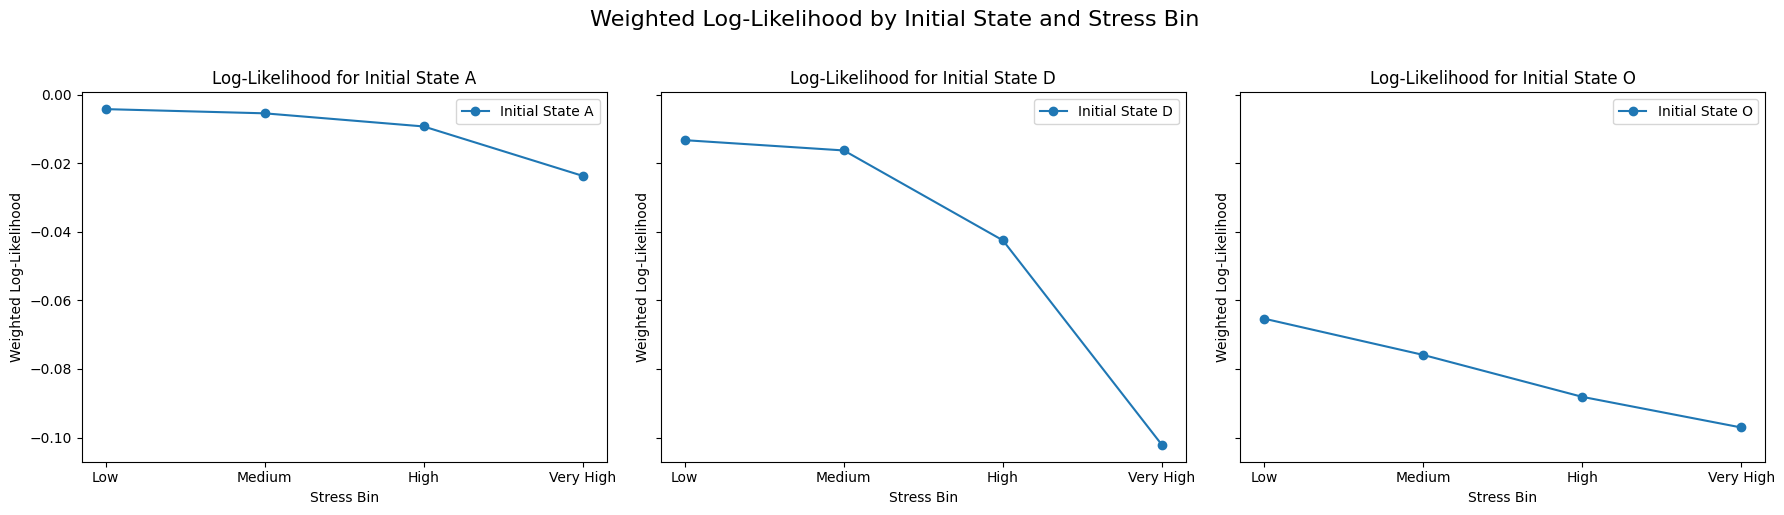

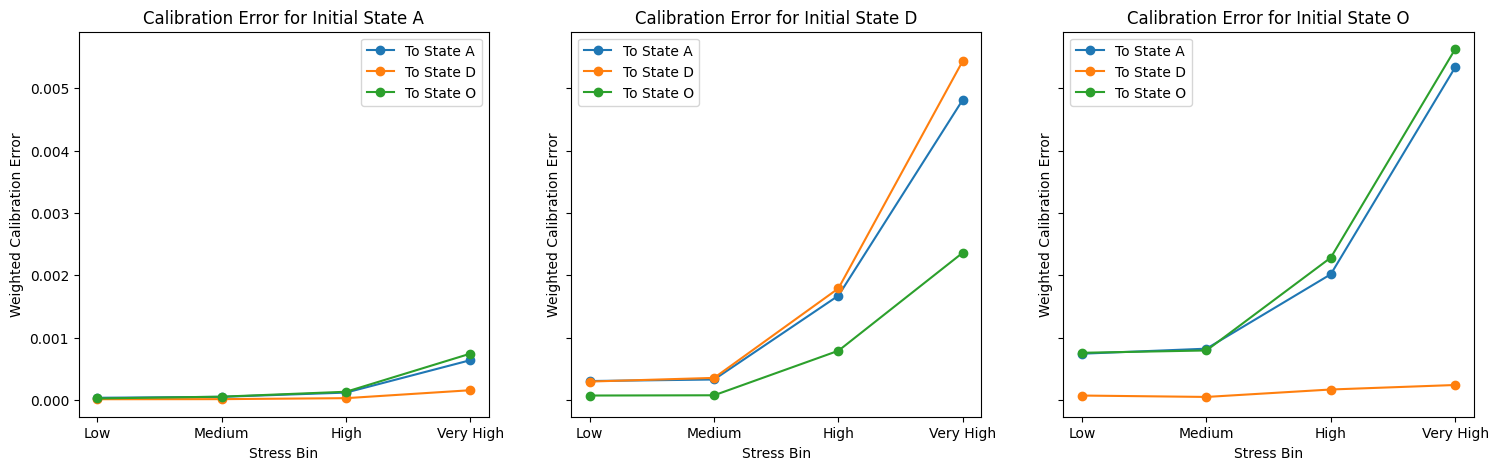

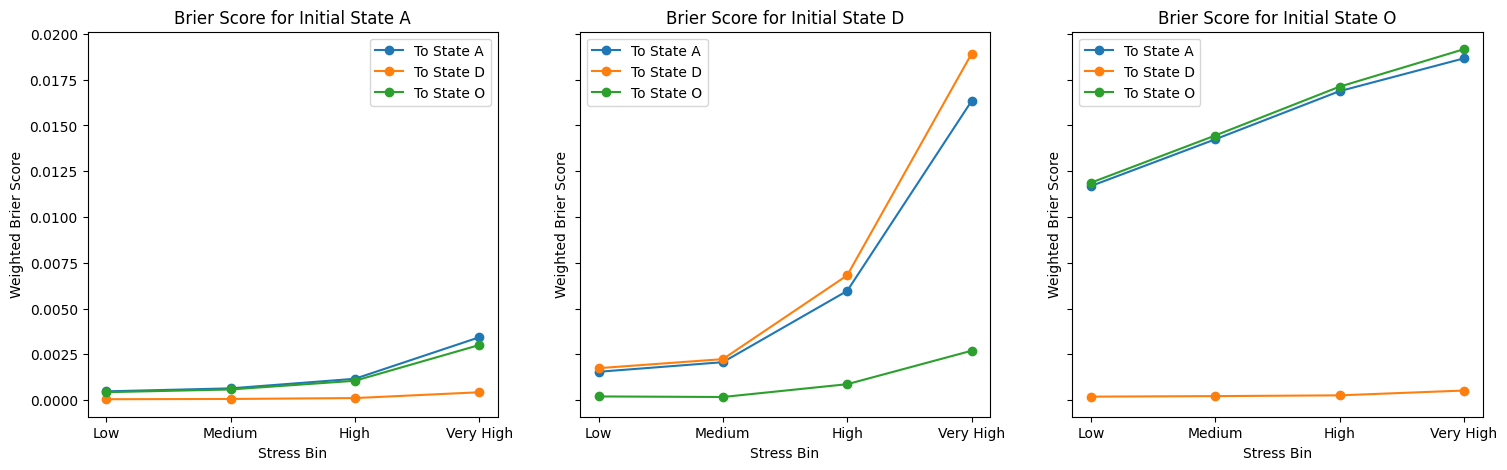

In [118]:
# plot results
# Log-Likelihood
ll_results_df = pd.DataFrame(ll_results).T
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
i = 0
for init_state, row in ll_results_df.iterrows():
    axs[i].plot(row.index, row.values, marker='o', label=f'Initial State {init_state}')
    axs[i].set_title(f'Log-Likelihood for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Log-Likelihood')
    axs[i].legend()
    i += 1
plt.suptitle('Weighted Log-Likelihood by Initial State and Stress Bin', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Weighted Calibration Error plots
idx2state = {0:'A', 1:'D', 2:'O'}

# Weighted Calibration Error
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
i=0
for init_state, state_results in weighted_calib_results.items():
    state_results_df = pd.DataFrame(state_results)
    for end_state, row in state_results_df.iterrows():
        axs[i].plot(row.index, row.values, marker='o', label=f'To State {idx2state[end_state]}')
    axs[i].set_title(f'Calibration Error for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Calibration Error')
    axs[i].legend()
    i += 1


# Brier Score plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
i=0
for init_state, state_results in brier_results.items():
    state_results_df = pd.DataFrame(state_results)
    for end_state, row in state_results_df.iterrows():
        axs[i].plot(row.index, row.values, marker='o', label=f'To State {idx2state[end_state]}')
    axs[i].set_title(f'Brier Score for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Brier Score')
    axs[i].legend()
    i += 1

In [212]:
def weighted_calibration_error(y_bin, p, w, bin_edges, eps=1e-12):
    y_bin = np.asarray(y_bin, float).reshape(-1)
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    p = np.clip(p, eps, 1 - eps)
    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)

    edges = bin_edges

    total_w = w.sum()
    if total_w <= 0:
        return np.nan

    ece = {}
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        p_bar = np.sum(w[m] * p[m]) / wb
        y_bar = np.sum(w[m] * y_bin[m]) / wb
        # e = (wb / total_w) * abs(y_bar - p_bar)
        e = abs(y_bar - p_bar)
        ece[(left, right)] = e

    return ece


def weighted_Brier_score(y_bin, p, w, bin_edges):
    edges = bin_edges
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)
    brier_score = {}
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        bri = np.sum(w[m] * (y_bin[m] - p[m])**2) / wb
        brier_score[(left, right)] = bri
    return brier_score


def cal_curve(y_bin, p, w, bin_edges):
    edges = bin_edges
    p     = np.asarray(p, float).reshape(-1)
    w     = np.asarray(w, float).reshape(-1)

    w = np.where(np.isfinite(w) & (w > 0), w, 0.0)
    cal_score_p = {}
    cal_score_f = {}
    for i in range(len(edges) - 1):
        left, right = edges[i], edges[i + 1]
        # include right edge in last bin
        if i == len(edges) - 2:
            m = (p >= left) & (p <= right)
        else:
            m = (p >= left) & (p < right)

        wb = w[m].sum()
        if wb <= 0:
            continue

        p_ = np.sum(w[m] * p[m]) / wb
        f_ = np.sum(w[m] * y_bin[m]) / wb
        cal_score_p[(left, right)] = p_
        cal_score_f[(left, right)] = f_
    return cal_score_p, cal_score_f


In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _weighted_calib_to_df(weighted_calib_results):
    rows = []
    for init_state, d_stress in weighted_calib_results.items():
        for stress_bin, d_end in d_stress.items():
            for end_state, d_bins in d_end.items():
                for (l, r), err in d_bins.items():
                    rows.append({
                        "init_state": init_state,
                        "stress_bin": stress_bin,
                        "end_state": int(end_state),
                        "bin_left": float(l),
                        "bin_right": float(r),
                        "err": float(err),
                    })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    return df.sort_values(["init_state", "end_state", "stress_bin", "bin_left"]).reset_index(drop=True)

def _format_tick(v, mode="percent"):
    if mode == "percent":
        return f"{100*v:.0f}%"
    elif mode == "float":
        return f"{v:.4f}"
    else:  # "sci"
        return f"{v:.1e}"

def plot_calibration_bars_by_transition(
    result_dict,
    init_states=("A", "D", "O"),
    end_states=(0, 1, 2),
    stress_bins=("Low", "Medium", "High", "Very High"),
    end_state_labels=None,
    figsize=(18, 10),
    x_mode="left",             # "left" or "center"
    sharey=False,
    max_bins=40,
    test_name='Brier Score',
    n_xticks=8,                # how many tick labels to show
    xtick_format="percent",     # "percent" | "float" | "sci"
    ytick_format="percent"     # "percent" | "float" | "sci"
):
    # ---- consistent stress-bin colors (yellow -> red) ----
    cmap = plt.cm.YlOrRd
    stress_colors = {
        stress: cmap((i + 1) / (len(stress_bins) + 1))
        for i, stress in enumerate(stress_bins)
    }
    df = _weighted_calib_to_df(result_dict)
    if df.empty:
        raise ValueError("No data found in weighted_calib_results.")

    if end_state_labels is None:
        end_state_labels = {s: str(s) for s in end_states}

    nrows, ncols = len(init_states), len(end_states)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharey=sharey)
    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)
    if ncols == 1:
        axs = np.expand_dims(axs, axis=1)

    for i, init_state in enumerate(init_states):
        for j, end_state in enumerate(end_states):
            ax = axs[i, j]
            sub = df[(df["init_state"] == init_state) & (df["end_state"] == end_state)].copy()

            if sub.empty:
                ax.set_axis_off()
                continue

            bins = (
                sub[["bin_left", "bin_right"]]
                .drop_duplicates()
                .sort_values(["bin_left", "bin_right"])
                .to_numpy()
            )

            if len(bins) > max_bins:
                bins = bins[:max_bins]
                keep = set(map(tuple, bins))
                sub = sub[sub.apply(lambda r: (r["bin_left"], r["bin_right"]) in keep, axis=1)]

            nB = len(bins)
            x = np.arange(nB)

            k = len(stress_bins)
            group_width = 0.85
            bar_w = group_width / max(1, k)
            offsets = (np.arange(k) - (k - 1) / 2.0) * bar_w

            bin_to_idx = {(float(l), float(r)): idx for idx, (l, r) in enumerate(bins)}

            for s_idx, stress in enumerate(stress_bins):
                ss = sub[sub["stress_bin"] == stress]
                if ss.empty:
                    continue
                y = np.full(nB, np.nan, dtype=float)
                for row in ss.itertuples(index=False):
                    key = (float(row.bin_left), float(row.bin_right))
                    if key in bin_to_idx:
                        y[bin_to_idx[key]] = float(row.err)

                # ax.bar(x + offsets[s_idx], y, width=bar_w, label=stress)
                ax.bar(
                        x + offsets[s_idx],
                        y,
                        width=bar_w,
                        label=stress,
                        color=stress_colors[stress],
                        edgecolor="black",
                        linewidth=0.3,
                    )

            # ---- BETTER X AXIS TICKS (sparse + clean) ----
            if x_mode == "center":
                xvals = 0.5 * (bins[:, 0] + bins[:, 1])
                xlabel = "Probability bin (center)"
            else:
                xvals = bins[:, 0]
                xlabel = "Probability bin (left edge)"

            n_ticks = min(n_xticks, nB)
            tick_idx = np.unique(np.round(np.linspace(0, nB - 1, n_ticks)).astype(int))
            ax.set_xticks(tick_idx)
            ax.set_xticklabels([_format_tick(xvals[t], xtick_format) for t in tick_idx], rotation=0)
            ax.set_xlabel(xlabel if i == nrows - 1 else "")

            # ---- Y AXIS TICKS ----
            yvals = ax.get_yticks()
            n_ticks_y = len(yvals)
            # tick_idx_y = np.unique(np.round(np.linspace(0, len(yvals) - 1, n_ticks_y)).astype(int))
            ax.set_yticks(yvals)
            ax.set_yticklabels([_format_tick(y, ytick_format) for y in yvals])
            if j == 0:
                # ax.set_ylabel("Calibration error")
                ax.set_ylabel(test_name)

            if i == 0:
                ax.set_title(f"End state: {end_state_labels.get(end_state, end_state)}")
            if j == 0:
                # ax.set_ylabel(f"Init {init_state}\nCalib error")
                 ax.set_ylabel(f"Init {init_state}\n{test_name}")

            ax.grid(axis="y", alpha=0.3)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(stress_bins), 4), frameon=False)

    plt.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

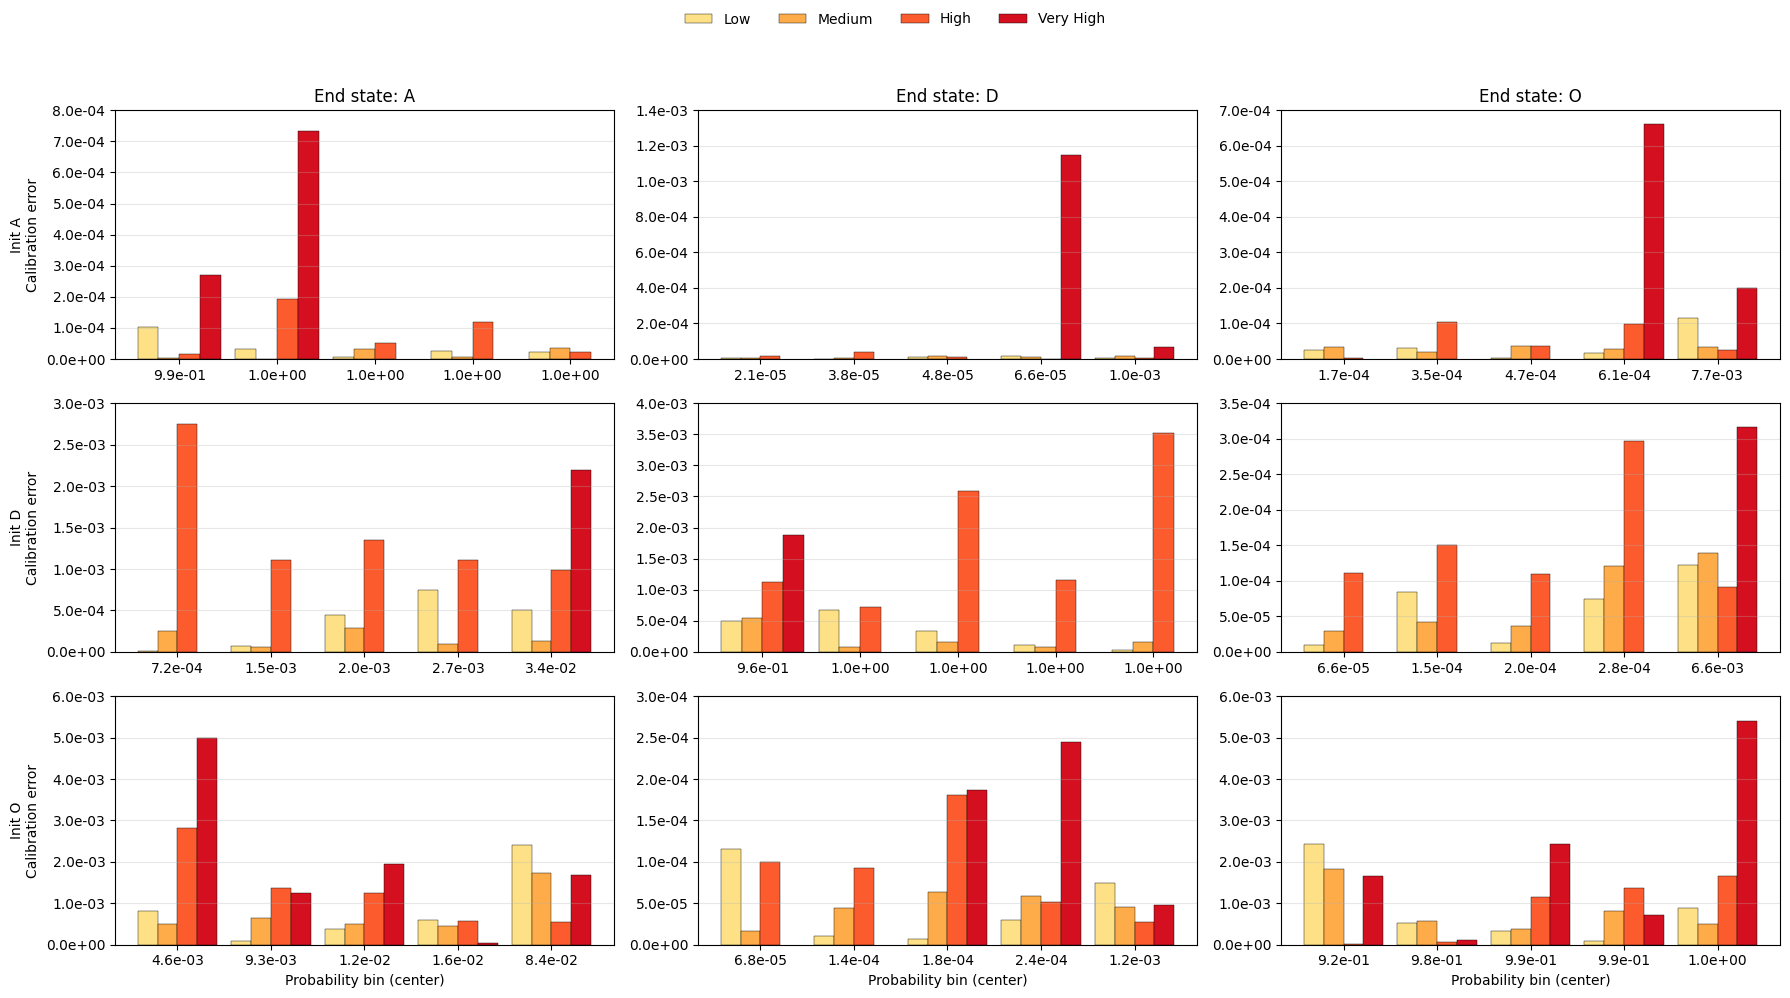

In [215]:
idx2state = {0:"A", 1:"D", 2:"O"}

plot_calibration_bars_by_transition(
    weighted_calib_results,
    init_states=("A","D","O"),
    end_states=(0,1,2),
    stress_bins=("Low","Medium","High","Very High"),
    end_state_labels=idx2state,
    x_mode="center",   # or "center"
    max_bins=30,      # tweak if you have tons of bins
    n_xticks=5,
    test_name='Calibration error',
    xtick_format="sci",
    ytick_format="sci"
)

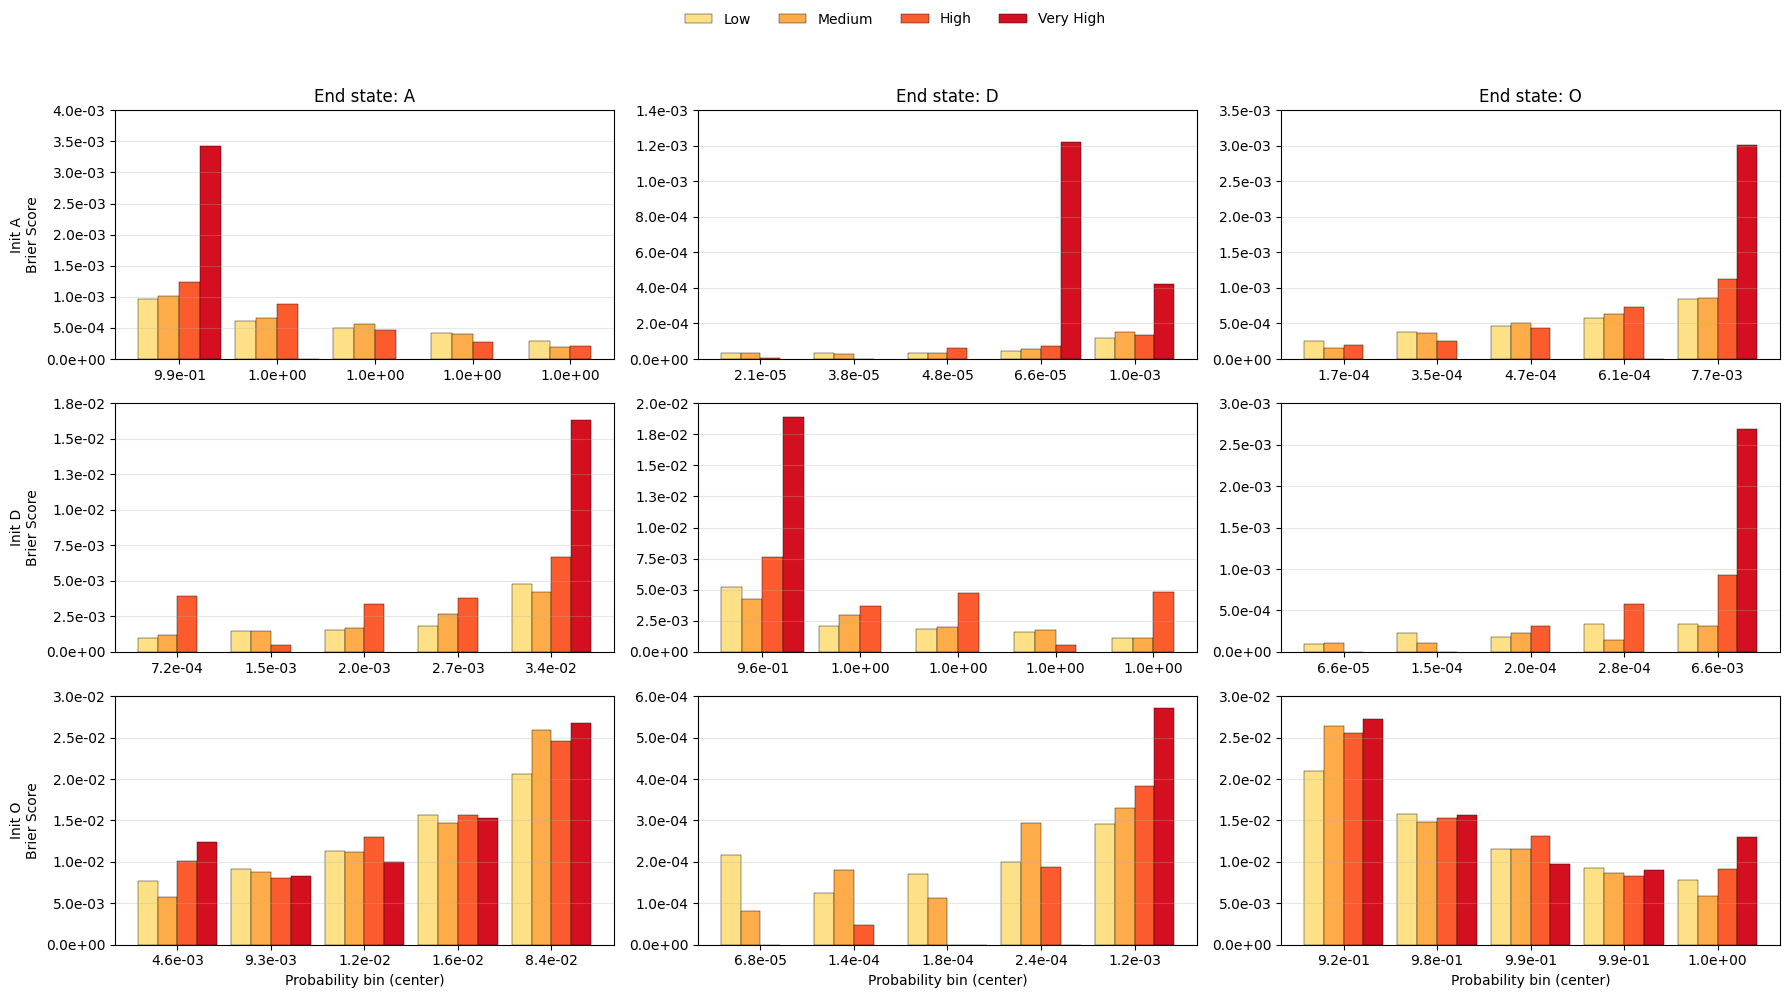

In [216]:
idx2state = {0:"A", 1:"D", 2:"O"}

plot_calibration_bars_by_transition(
    brier_results,
    init_states=("A","D","O"),
    end_states=(0,1,2),
    stress_bins=("Low","Medium","High","Very High"),
    end_state_labels=idx2state,
    x_mode="center",   # or "center"
    max_bins=30,      # tweak if you have tons of bins
    n_xticks=5,
    test_name='Brier Score',
    xtick_format="sci",
    ytick_format="sci"
)

In [257]:
import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_by_transition(
    result_dict,
    init_states=("A", "D", "O"),
    end_states=(0, 1, 2),
    stress_bins=("Low", "Medium", "High", "Very High"),
    end_state_labels=None,        # e.g. {0:"A",1:"D",2:"O"}
    figsize=(18, 10),
    sharey=False,
    sharex=False,
    show_markers=True,
    marker_size=20,
    line_width=1.8,
    alpha=0.9,
    show_counts=False,            # if you later store counts per bin
):
    # --- labels ---
    if end_state_labels is None:
        end_state_labels = {s: str(s) for s in end_states}

    # --- consistent stress-bin colors (yellow -> red) ---
    cmap = plt.cm.YlOrRd
    stress_colors = {
        stress: cmap((i + 1) / (len(stress_bins) + 1))
        for i, stress in enumerate(stress_bins)
    }

    nrows, ncols = len(init_states), len(end_states)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)

    if nrows == 1:
        axs = np.expand_dims(axs, axis=0)
    if ncols == 1:
        axs = np.expand_dims(axs, axis=1)

    # collect handles for a single shared legend
    legend_handles = {}
    perfect_handle = None

    for i, init_state in enumerate(init_states):
        for j, end_state in enumerate(end_states):
            ax = axs[i, j]

            # diagonal + formatting first
            # perfect_handle = ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2, color="gray")[0]
            # ax.set_xlim(0, 1)
            # ax.set_ylim(0, 1)
            ax.set_aspect("equal", adjustable="box")
            ax.grid(True, alpha=0.25)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            # plot each stress bin
            any_curve = False
            max_val, min_val = 0.0, 1.0
            for stress in stress_bins:
                # your structure: result_dict['p'][init_state][stress][end_state] is dict of bins -> value
                try:
                    sub = list(result_dict["p"][init_state][stress][end_state].values())
                    f_sub = list(result_dict["f"][init_state][stress][end_state].values())
                except KeyError:
                    continue

                if len(sub) == 0 or len(f_sub) == 0:
                    continue

                # sort by predicted prob so lines don’t zig-zag
                sub = np.asarray(sub, dtype=float)
                f_sub = np.asarray(f_sub, dtype=float)
                order = np.argsort(sub)
                sub = sub[order]
                f_sub = f_sub[order]

                # h = ax.plot(
                #     sub,
                #     f_sub,
                #     linestyle="-",
                #     linewidth=line_width,
                #     color=stress_colors[stress],
                #     alpha=alpha,
                #     marker="o" if show_markers else None,
                #     markersize=marker_size,
                # )[0]
                h = ax.scatter(
                    sub,
                    f_sub,
                    color=stress_colors[stress],
                    alpha=alpha,
                    s=marker_size,
                )

                legend_handles.setdefault(stress, h)
                any_curve = True

                max_val = max([max_val, max(sub), max(f_sub)])
                min_val = min([ min_val, min(sub), min(f_sub)])
            
            perfect_handle = ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", linewidth=1.2, color="gray")[0]

            if not any_curve:
                ax.set_axis_off()
                continue

            # titles + axis labels
            if i == 0:
                ax.set_title(f"End: {end_state_labels.get(end_state, end_state)}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Init {init_state}\nObserved frequency", fontsize=11)
            if i == nrows - 1:
                ax.set_xlabel("Predicted probability", fontsize=11)

    # shared legend
    handles = [legend_handles[s] for s in stress_bins if s in legend_handles]
    labels = [s for s in stress_bins if s in legend_handles]
    if perfect_handle is not None:
        handles = handles + [perfect_handle]
        labels = labels + ["Perfect calibration"]

    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 5), frameon=False)

    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()

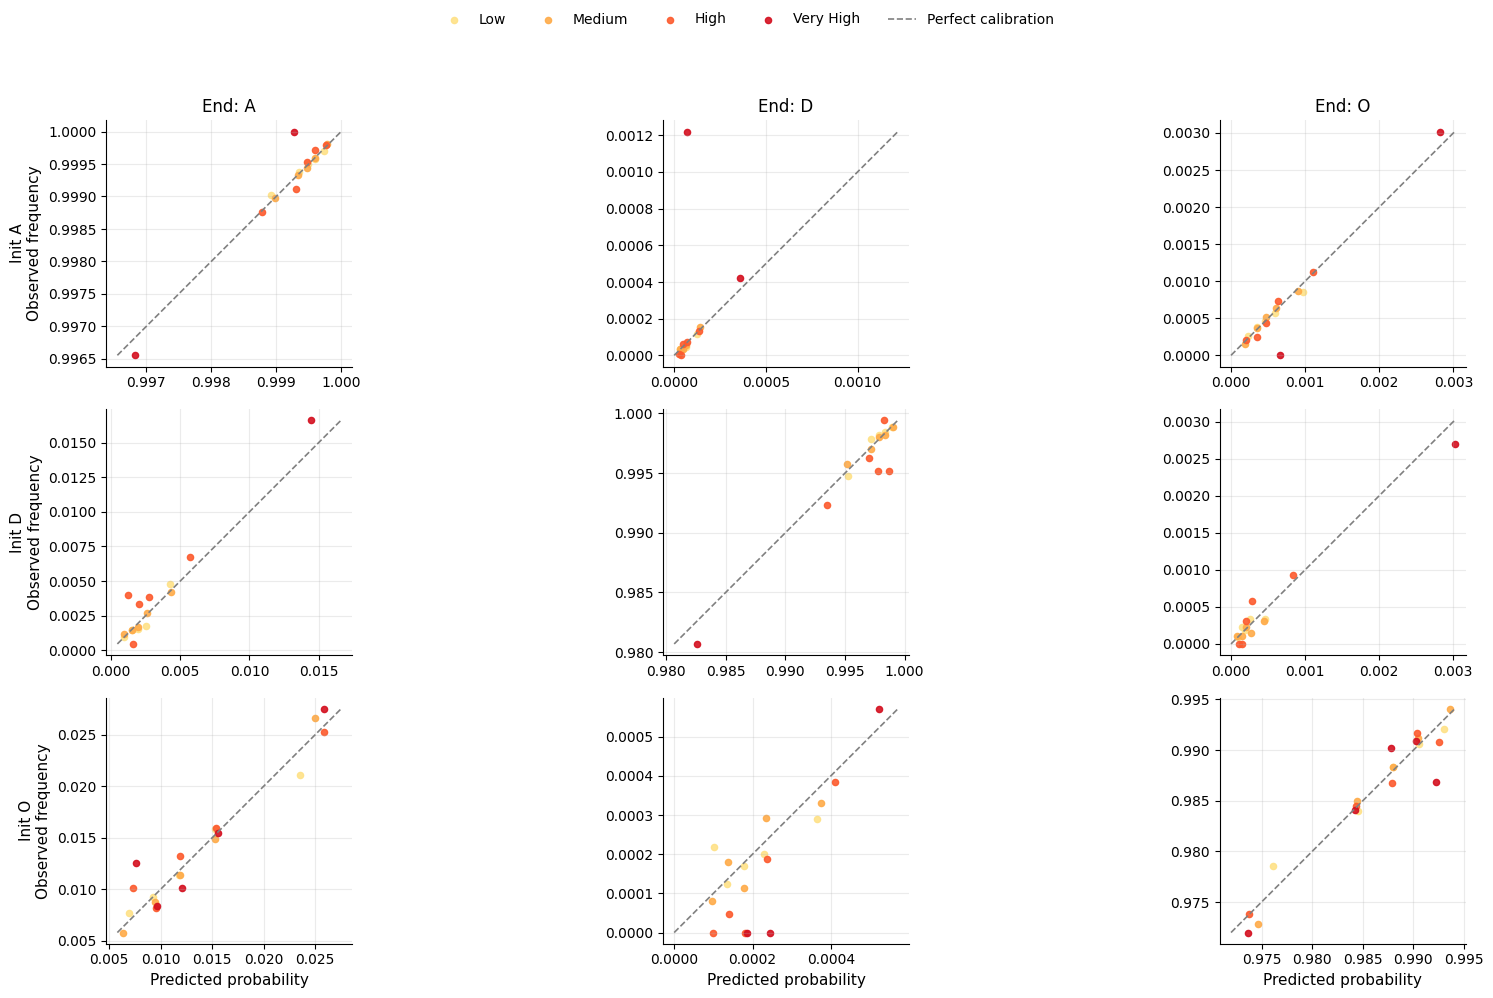

In [258]:
idx2state = {0:"A", 1:"D", 2:"O"}

plot_calibration_by_transition(
    calibration_curve_data,
    init_states=("A","D","O"),
    end_states=(0,1,2),
    stress_bins=("Low","Medium","High","Very High"),
    end_state_labels=idx2state,
)

## Regional and Cross-Tabulated Evaluation

In [119]:
test_data

,Datetime_UTC,State,Initial_gen_state,Temperature,Load_CDF,psi1,psi2,psi3,psi4,Final_gen_state,w,w_region_final,w_stress,Data_weight
0,2015-07-01 06:00:00+00:00,NEW YORK,0.0,18.766392,0.246188,-1.534640,54.960411,39.371506,30.115234,0,1.074424,1.607372,1.972629,125.0
1,2015-07-01 06:00:00+00:00,SOUTH CAROLINA,2.0,21.350744,0.262334,-0.957323,58.157227,213.646393,0.000000,2,0.814156,0.582047,4.363229,2.0
2,2015-07-01 06:00:00+00:00,NEW JERSEY,0.0,22.500315,0.240954,-0.602309,58.901833,124.020462,2.471753,0,1.079534,1.153568,2.919122,83.0
3,2015-07-01 06:00:00+00:00,MICHIGAN,1.0,13.473194,0.231023,-2.662955,49.765976,20.902346,51.218033,1,0.818135,1.607372,1.430774,1.0
4,2015-07-01 06:00:00+00:00,INDIANA,0.0,17.143738,0.223242,-1.753848,52.752766,73.896080,7.735801,0,0.813834,1.454870,1.744898,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387356,2024-12-31 23:00:00+00:00,ILLINOIS,2.0,2.733730,0.627719,-13.976967,36.870354,0.000000,409.792664,2,0.831024,1.171416,2.212896,4.0
1387357,2024-12-31 23:00:00+00:00,MARYLAND,1.0,10.752639,0.657859,-9.372757,42.650867,0.000000,267.874847,1,0.391468,1.046393,1.166971,1.0
1387358,2025-01-01 00:00:00+00:00,MISSOURI,1.0,2.861022,0.714411,-15.816337,33.487904,0.000000,374.461395,1,0.857500,0.992913,2.693902,1.0
1387359,2025-01-01 00:00:00+00:00,COLORADO,0.0,-3.289231,0.798975,-22.602378,19.864616,0.000000,616.201233,2,5.056455,1.087448,16.034664,1.0


In [120]:
# roi = Region Of Interest
# row = Rest Of the World
ll_results_roi = defaultdict(dict)
ll_results_row = defaultdict(dict)
weighted_calib_results_roi = defaultdict(lambda: defaultdict(dict))
weighted_calib_results_row = defaultdict(lambda: defaultdict(dict))
brier_results_roi = defaultdict(lambda: defaultdict(dict))
brier_results_row = defaultdict(lambda: defaultdict(dict))

for initial_state_idx, initial_state in enumerate(['A', 'D', 'O']):
    print(f"\nEvaluating initial MC state: {initial_state}")
    for stress_bin, test_data_bin in test_data_stress_bins.items():
        print(f" Stress bin: {stress_bin} | N = {len(test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx])}")
        model = prob_models[initial_state]
        test_data_state = test_data_bin.loc[test_data_bin['Initial_gen_state'] == initial_state_idx].copy()

        # ROI
        test_data_state_roi = test_data_state.loc[test_data_state['State'] == region].copy()
        if len(test_data_state_roi) != 0:
            p_test_roi = model.predict_proba(test_data_state_roi)
            y_test_roi = test_data_state_roi['Final_gen_state'].to_numpy(dtype=int)
            w_imp_roi = test_data_state_roi['w_stress'].to_numpy(dtype=float)
            # w_imp_roi = np.ones_like(y_test_roi, dtype=float)
            w_cmp_roi = test_data_state_roi['Data_weight'].to_numpy(dtype=float)
            w_test_roi = w_imp_roi * w_cmp_roi

            ll_roi = weighted_log_likelihood(y_test_roi, p_test_roi, w_test_roi)
            ll_results_roi[initial_state][stress_bin] = ll_roi

            for end_state in [0,1,2]:
                y_bin_roi = (y_test_roi == end_state).astype(float)
                p_bin_roi = p_test_roi[:, end_state]

                calib_err_roi = weighted_calibration_error(y_bin_roi, p_bin_roi, w_test_roi, n_bins=10, strategy="quantile")
                brier_roi     = weighted_Brier_score(y_bin_roi, p_bin_roi, w_test_roi)

                weighted_calib_results_roi[initial_state][stress_bin][end_state] = calib_err_roi
                brier_results_roi[initial_state][stress_bin][end_state] = brier_roi
        else:
            ll_results_roi[initial_state][stress_bin] = np.nan
            for end_state in [0,1,2]:
                weighted_calib_results_roi[initial_state][stress_bin][end_state] = np.nan
                brier_results_roi[initial_state][stress_bin][end_state] = np.nan
        
        # ROW
        test_data_state_row = test_data_state.loc[test_data_state['State'] != region].copy()
        if len(test_data_state_row) != 0:
            p_test_row = model.predict_proba(test_data_state_row)
            y_test_row = test_data_state_row['Final_gen_state'].to_numpy(dtype=int)
            w_imp_row = test_data_state_row['w_stress'].to_numpy(dtype=float)
            # w_imp_row = np.ones_like(y_test_row, dtype=float)
            w_cmp_row = test_data_state_row['Data_weight'].to_numpy(dtype=float)
            w_test_row = w_imp_row * w_cmp_row

            ll_row = weighted_log_likelihood(y_test_row, p_test_row, w_test_row)
            ll_results_row[initial_state][stress_bin] = ll_row

            for end_state in [0,1,2]:
                y_bin_row = (y_test_row == end_state).astype(float)
                p_bin_row = p_test_row[:, end_state]

                calib_err_row = weighted_calibration_error(y_bin_row, p_bin_row, w_test_row, n_bins=10, strategy="quantile")
                brier_row     = weighted_Brier_score(y_bin_row, p_bin_row, w_test_row)

                weighted_calib_results_row[initial_state][stress_bin][end_state] = calib_err_row
                brier_results_row[initial_state][stress_bin][end_state] = brier_row
        else:
            ll_results_row[initial_state][stress_bin] = np.nan
            for end_state in [0,1,2]:
                weighted_calib_results_row[initial_state][stress_bin][end_state] = np.nan
                brier_results_row[initial_state][stress_bin][end_state] = np.nan
        # 
    # 


Evaluating initial MC state: A
 Stress bin: Low | N = 377188
 Stress bin: Medium | N = 294755
 Stress bin: High | N = 67193
 Stress bin: Very High | N = 7244

Evaluating initial MC state: D
 Stress bin: Low | N = 116824
 Stress bin: Medium | N = 98437
 Stress bin: High | N = 18900
 Stress bin: Very High | N = 1881

Evaluating initial MC state: O
 Stress bin: Low | N = 199668
 Stress bin: Medium | N = 161752
 Stress bin: High | N = 38770
 Stress bin: Very High | N = 4749


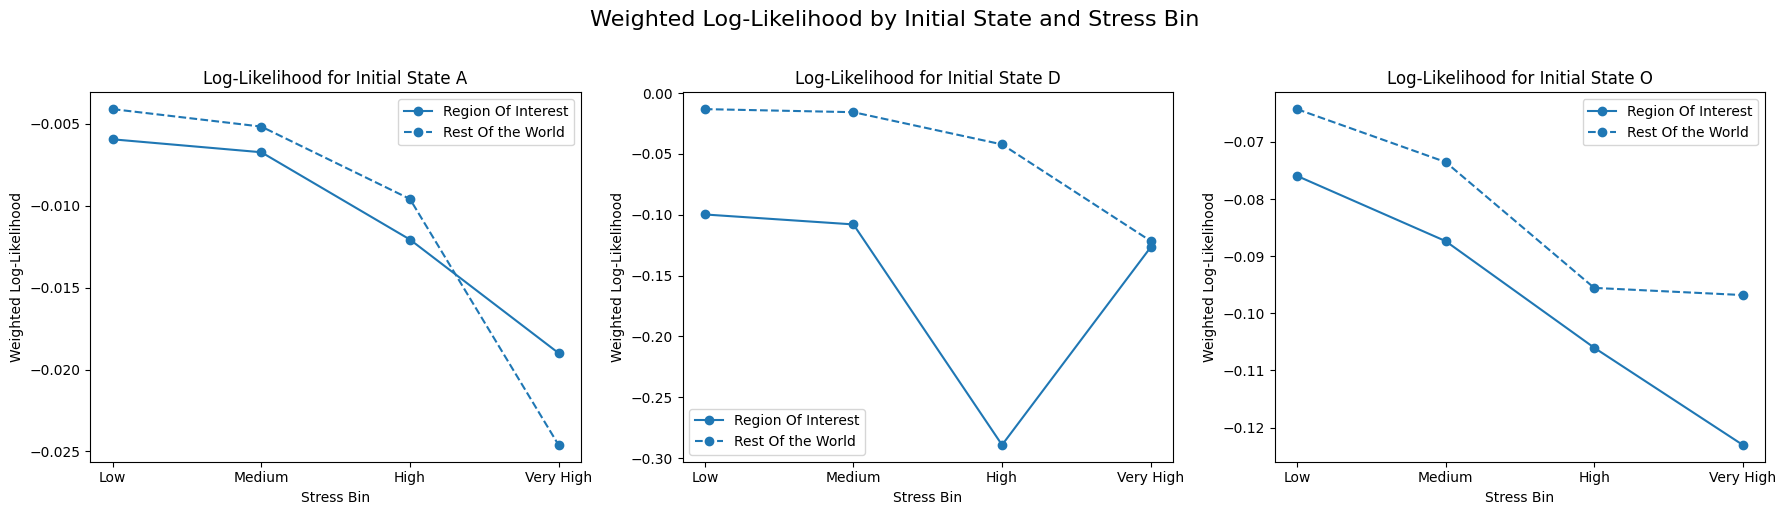

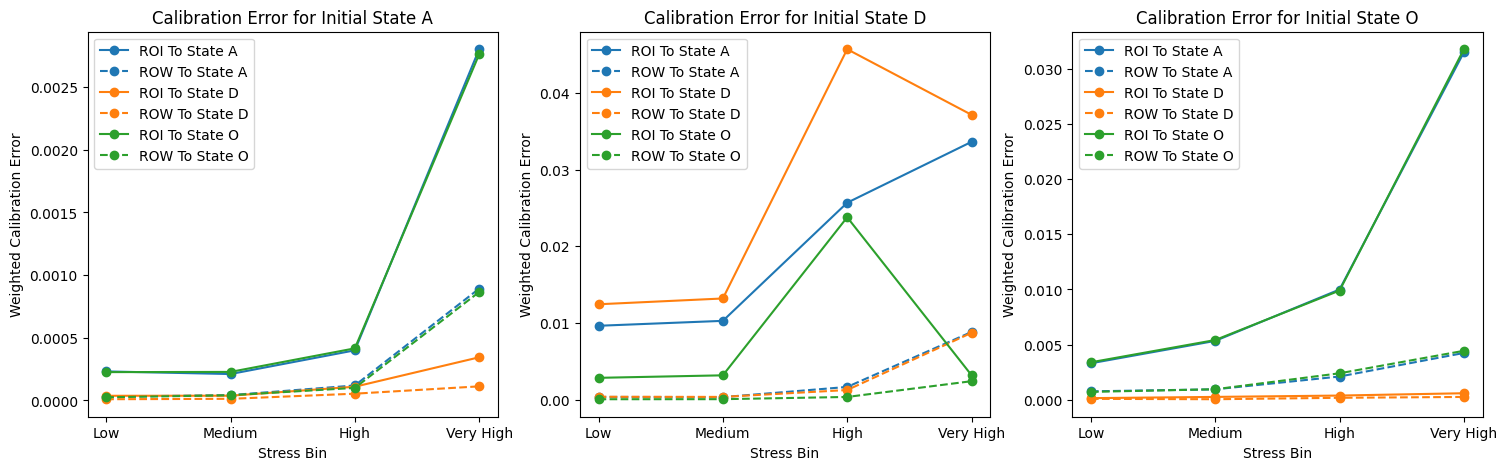

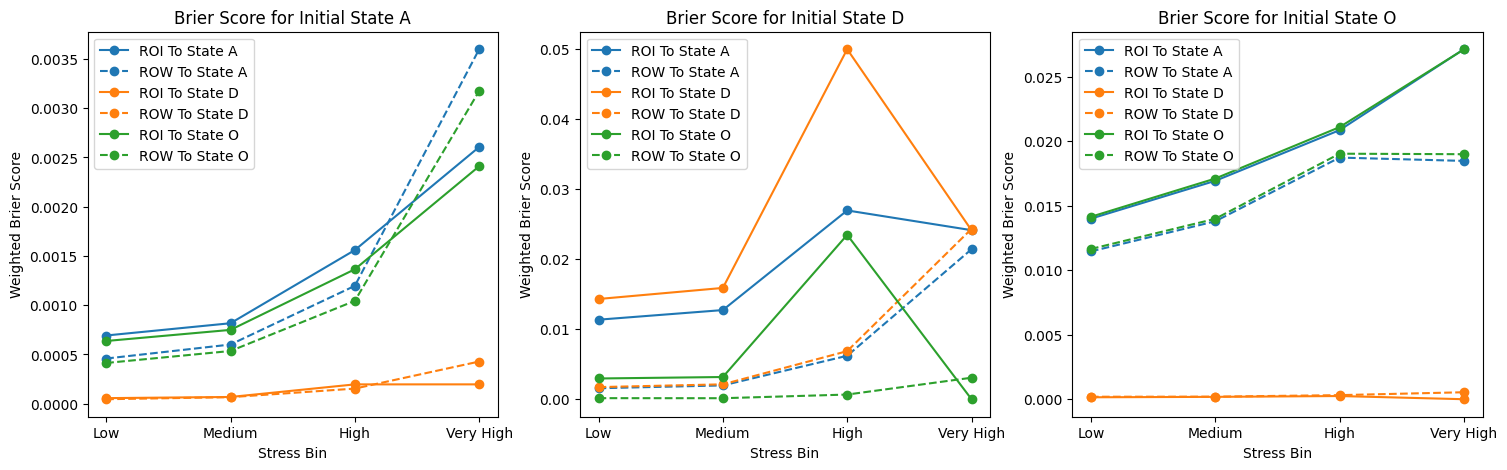

In [121]:
# plot results
# Log-Likelihood
ll_results_roi_df = pd.DataFrame(ll_results_roi).T
ll_results_row_df = pd.DataFrame(ll_results_row).T
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
i = 0
for init_state in ['A', 'D', 'O']:
    roi_row = ll_results_roi_df.loc[init_state]
    row_row = ll_results_row_df.loc[init_state]
    axs[i].plot(roi_row.index, roi_row.values, marker='o', color='tab:blue', label='Region Of Interest')
    axs[i].plot(row_row.index, row_row.values, marker='o', color='tab:blue',  linestyle='--',  label='Rest Of the World')
    axs[i].set_title(f'Log-Likelihood for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Log-Likelihood')
    axs[i].legend()
    i += 1
plt.suptitle('Weighted Log-Likelihood by Initial State and Stress Bin', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Weighted Calibration Error plots
idx2state = {0:'A', 1:'D', 2:'O'}

# Weighted Calibration Error
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
i=0
colors = ['tab:blue', 'tab:orange', 'tab:green']
for init_state in ['A', 'D', 'O']:
    roi_state_results = weighted_calib_results_roi[init_state]
    row_state_results = weighted_calib_results_row[init_state]
    roi_state_results_df = pd.DataFrame(roi_state_results)
    row_state_results_df = pd.DataFrame(row_state_results)
    for j, end_state in enumerate(roi_state_results_df.index):
        axs[i].plot(roi_state_results_df.columns, roi_state_results_df.loc[end_state], marker='o', color=colors[j], label=f'ROI To State {idx2state[end_state]}')
        axs[i].plot(row_state_results_df.columns, row_state_results_df.loc[end_state], marker='o', color=colors[j], linestyle='--', label=f'ROW To State {idx2state[end_state]}')
    axs[i].set_title(f'Calibration Error for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Calibration Error')
    axs[i].legend()
    i += 1


# Brier Score plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
i=0
for init_state in ['A', 'D', 'O']:
    roi_state_results = brier_results_roi[init_state]
    row_state_results = brier_results_row[init_state]
    roi_state_results_df = pd.DataFrame(roi_state_results)
    row_state_results_df = pd.DataFrame(row_state_results)
    for j, end_state in enumerate(roi_state_results_df.index):
        axs[i].plot(roi_state_results_df.columns, roi_state_results_df.loc[end_state], marker='o', color=colors[j], label=f'ROI To State {idx2state[end_state]}')
        axs[i].plot(row_state_results_df.columns, row_state_results_df.loc[end_state], marker='o', color=colors[j], linestyle='--', label=f'ROW To State {idx2state[end_state]}')
    axs[i].set_title(f'Brier Score for Initial State {init_state}')
    axs[i].set_xlabel('Stress Bin')
    axs[i].set_ylabel('Weighted Brier Score')
    axs[i].legend()
    i += 1